This code was based on in the following references:

[1] "Particle Swarm Optimization" published in 1995 by James Kennedy and Russell Eberhart

[2] "A New Optimizer Using Particle Swarm Theory" published in 1995 by James Kennedy and Russell Eberhart

[3] "A Novel Search Algorithm based on Fish School Behavior" published in 2008 by Bastos Filho, Lima Neto, Lins, D. O. Nascimento and P. Lima

[4] "An Enhanced Fish School Search Algorithm" published in 2013 by Bastos Filho and  D. O. Nascimento

[5] "Defining a Standard for Particle Swarm Optimization" published in 2007 by Bratton and Kennedy

signal ranked wilcoxon non-parametrical test

https://ieeexplore.ieee.org/document/8790158

https://arxiv.org/abs/2201.00523

https://titan.csit.rmit.edu.au/~e46507/cec13-niching/competition/cec2013-niching-benchmark-tech-report.pdf

### Imports

In [1]:
import os
import sys
import csv
import random
import copy
import math
import time
import datetime
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy.stats as sts
from random import randint
from IPython.display import display, HTML
from google.colab import drive, files
%matplotlib inline
plt.rcParams["figure.figsize"] = (18,9)

### Connection with Google Drive

In [2]:
drive.mount('/content/drive', force_remount=True) #  Connect to drive
FOLDERNAME = 'POLI/decimo/tcc/Algoritms/Results/' #  Set folder that have the datasts
assert FOLDERNAME is not None, "[!] Enter the foldername."
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME)) #  Locale the foldeer

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/POLI/decimo/tcc/Algoritms/Results


### Validation 30 bests execution of each algoritms

Get files CVSs that contains informations about many executions that have the bests values found by each algoritm. The algoritms are PSO, GWO and FSS and they has 30 execution with 1K iterations for the same objective functions with the same dimention.

- `Colocar escalas nos gráficos unificados`
- `Reajustar as escalas de log que estão quebrando` (https://stackoverflow.com/questions/16904755/logscale-plots-with-zero-values-in-matplotlib)
- `Adição de dimensão 50 e 100`
- `Adaptar convergencia para apenas na hora de apresentar tentar permanecer com o minimo até que tenha outro minimo (melhor que ele) encontrado`
- `Adição novamente do PSO (revisão de Rodrigo)`
- Wilcoxon para explicar melhor os resultados obtidos nele (reunião com Rodrigo)

In [3]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_100 = []
files_50 = []
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/100d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_100.append(df)
  filename = f"{filepath}/50d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_50.append(df)
  filename = f"{filepath}/30d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_exec.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results_50 = pd.concat(files_50)
results_50.sort_values(by=['func'], ascending=False)
results_100 = pd.concat(files_100)
results_100.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30, 50: results_50, 100: results_100}
results[30].head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,PSO,Sphere,104.020798,1.189816e-14,6.452584e-14,5.343616e-16,1.521533e-14,2.744813e-16,1.020645e-17,3.371347e-16,...,1.600004e-17,4.640686e-15,2.621440e+01,6.613299e-15,6.639569e-16,9.031412e-17,2.596545e-16,1.495277e-14,2.502873e-13,9.964517e-17
1,PSO,RotatedHyperEllipsoid,273.261425,1.288490e+04,1.031792e-12,8.589935e+03,5.078050e-14,9.762258e-13,4.160658e-11,3.865471e+04,...,3.435974e+04,4.215491e-14,1.666447e-14,2.392591e-13,4.294967e+04,2.286736e-13,4.294967e+03,4.294967e+03,2.256705e-13,2.576980e+04
2,PSO,Rosenbrock,120.415957,5.141760e+04,5.300296e+04,5.141760e+04,3.262820e-01,5.300035e+04,1.835971e+00,1.801133e+00,...,1.059547e+05,1.835971e+00,9.300770e+04,4.669675e+04,5.141760e+04,5.299262e+04,5.282857e+04,5.299304e+04,5.569839e-01,5.300015e+04
3,PSO,Dixon-Price,138.923465,7.855875e-10,3.105272e-09,5.349204e-04,8.100000e+01,8.100000e+01,1.185726e+01,8.100000e+01,...,5.684342e+05,8.100000e+01,8.100000e+01,3.312978e-03,8.100000e+01,6.030478e-10,2.732653e-05,8.100000e+01,8.100000e+01,8.100000e+01
4,PSO,Quartic-Noise,121.109640,8.324468e-02,1.485862e-02,4.028924e-02,2.684111e-02,3.072502e-02,4.219110e-02,2.355344e-02,...,1.608589e-02,1.075598e+01,1.525556e-02,1.448238e-02,1.198013e-02,3.986144e-02,3.098941e-02,2.950255e-02,2.596201e-02,1.786020e-02


We separete in each objective functions and comparete each algoritm to show the best score found in each execution. Unfortunately the PSO shows in many execution a big score, it became the GWO and FSS visualization difficult.

Functions w/ 15 dim


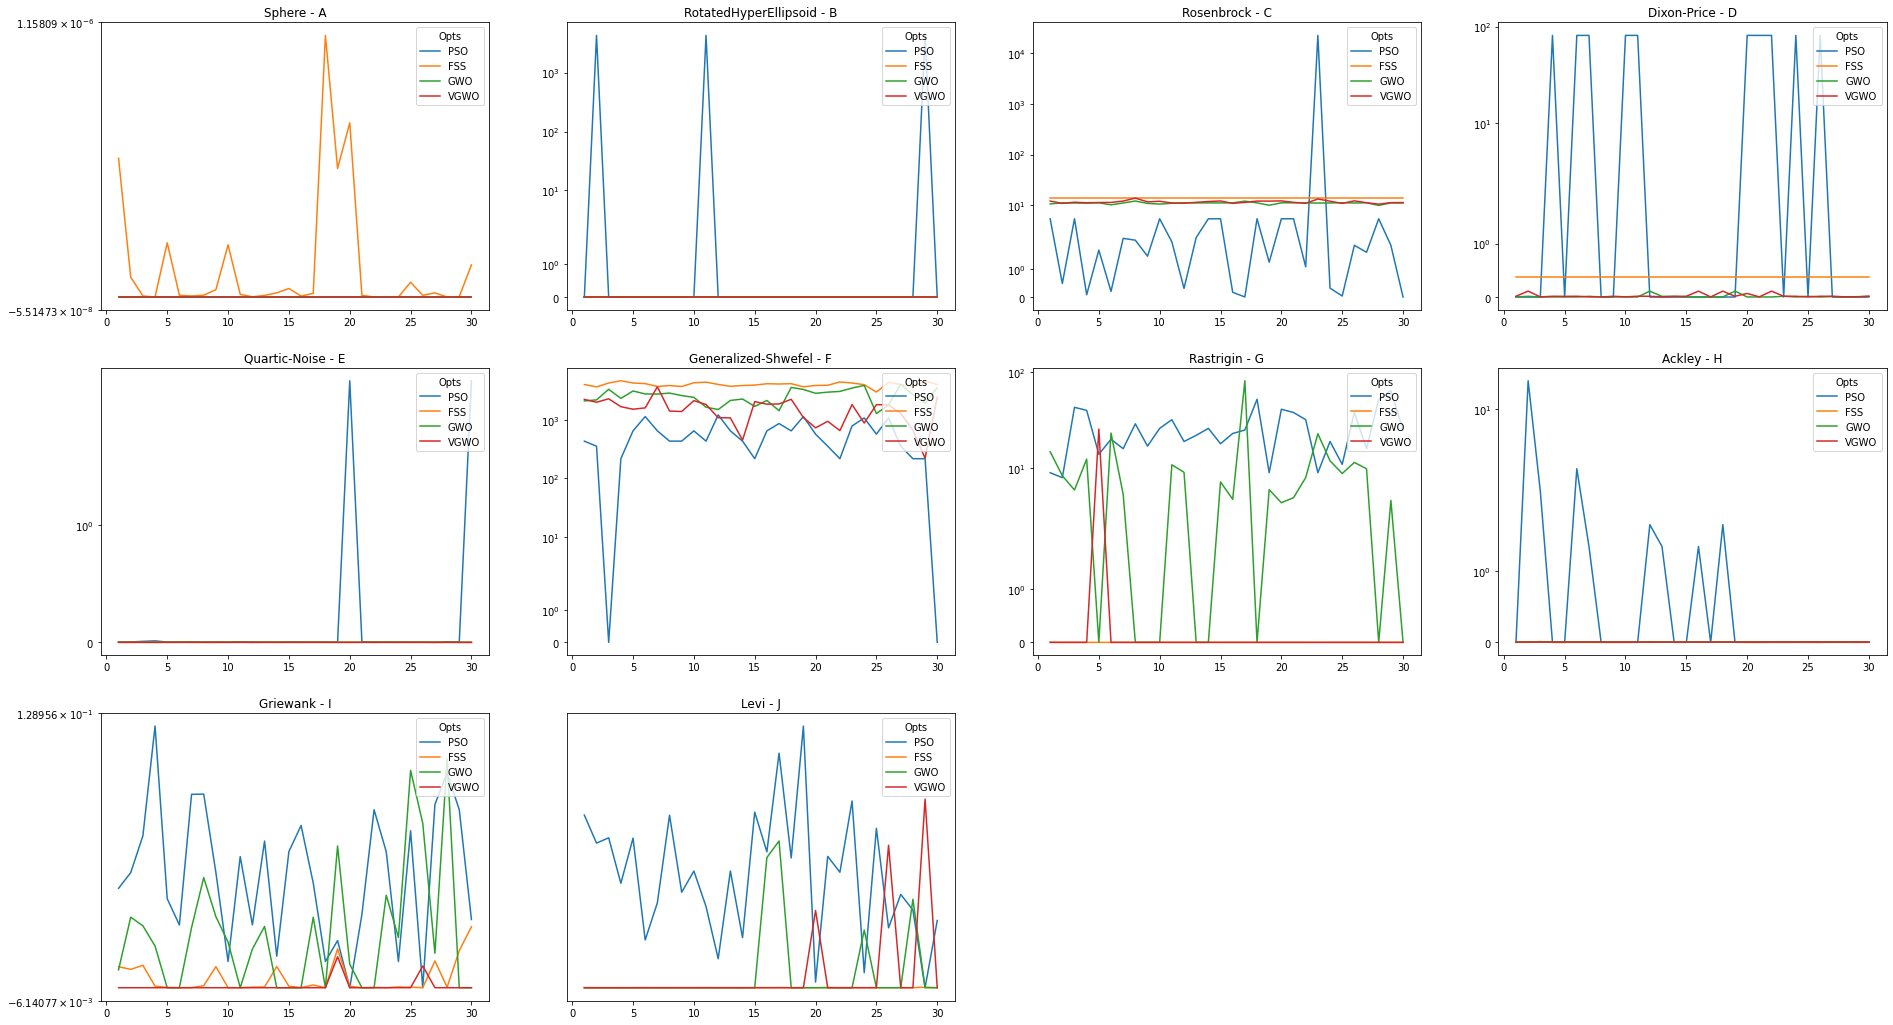

Functions w/ 30 dim


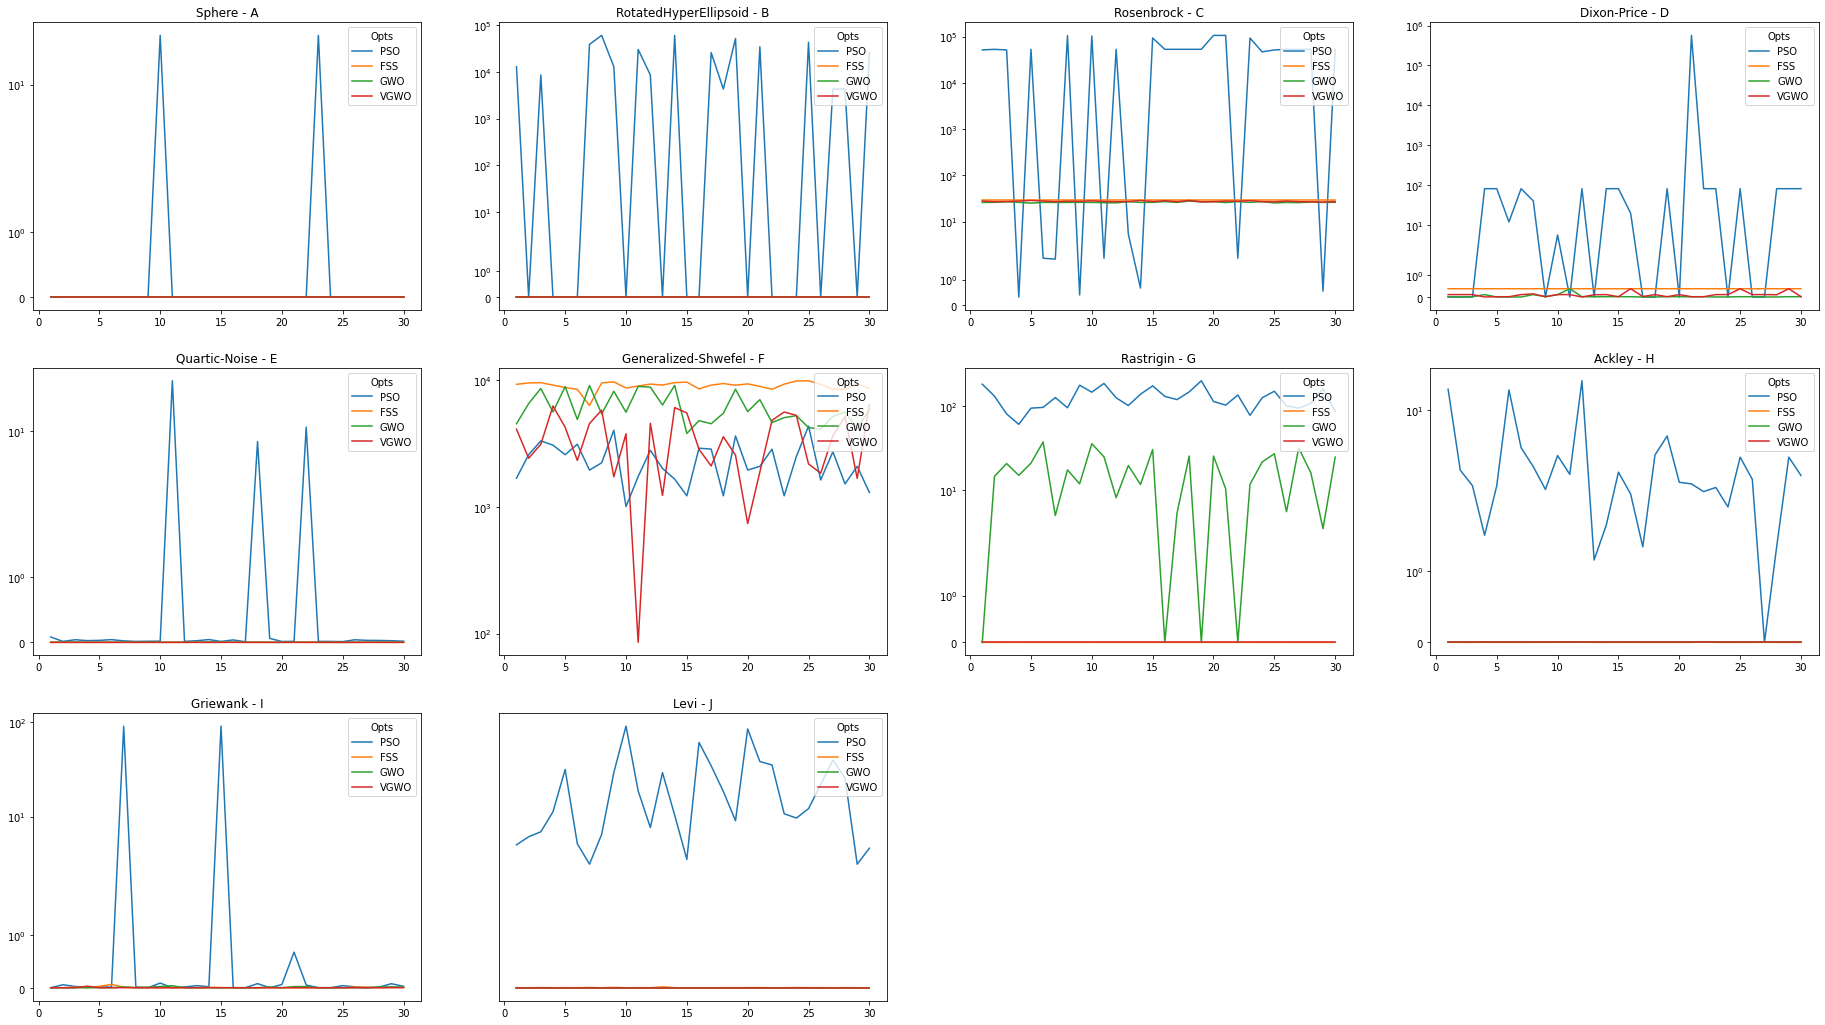

Functions w/ 50 dim


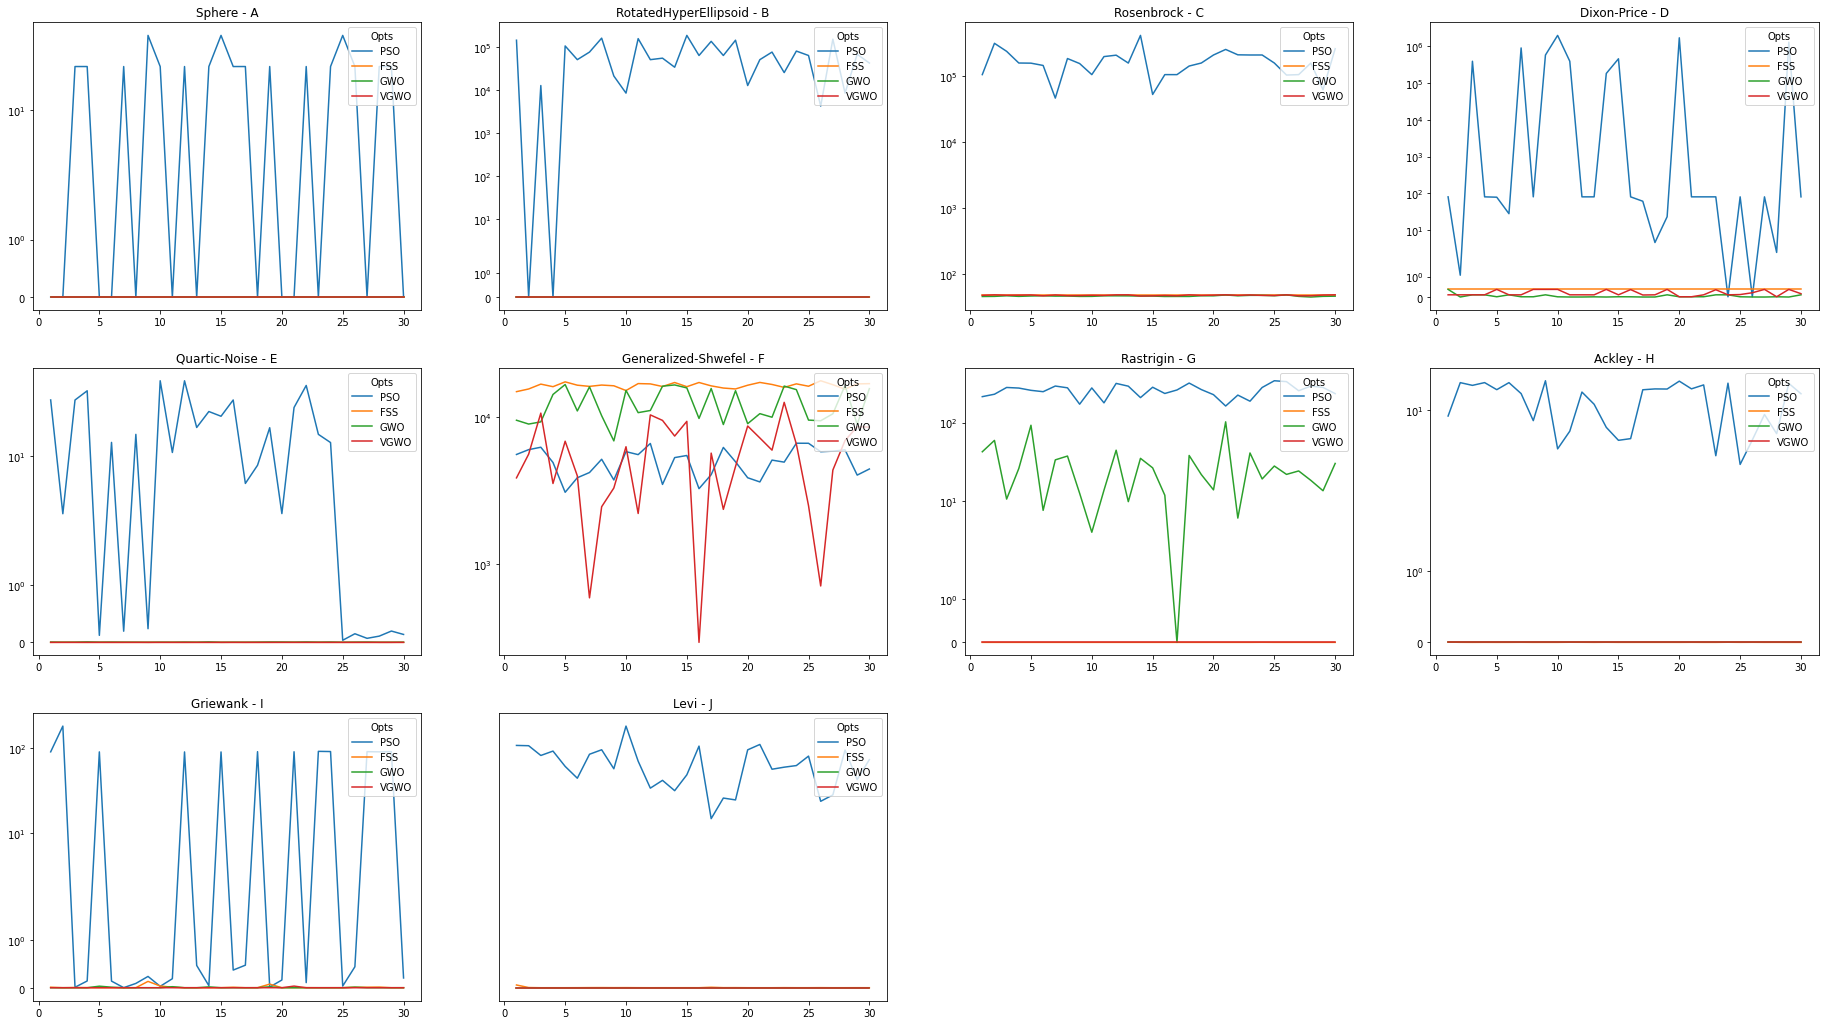

Functions w/ 100 dim


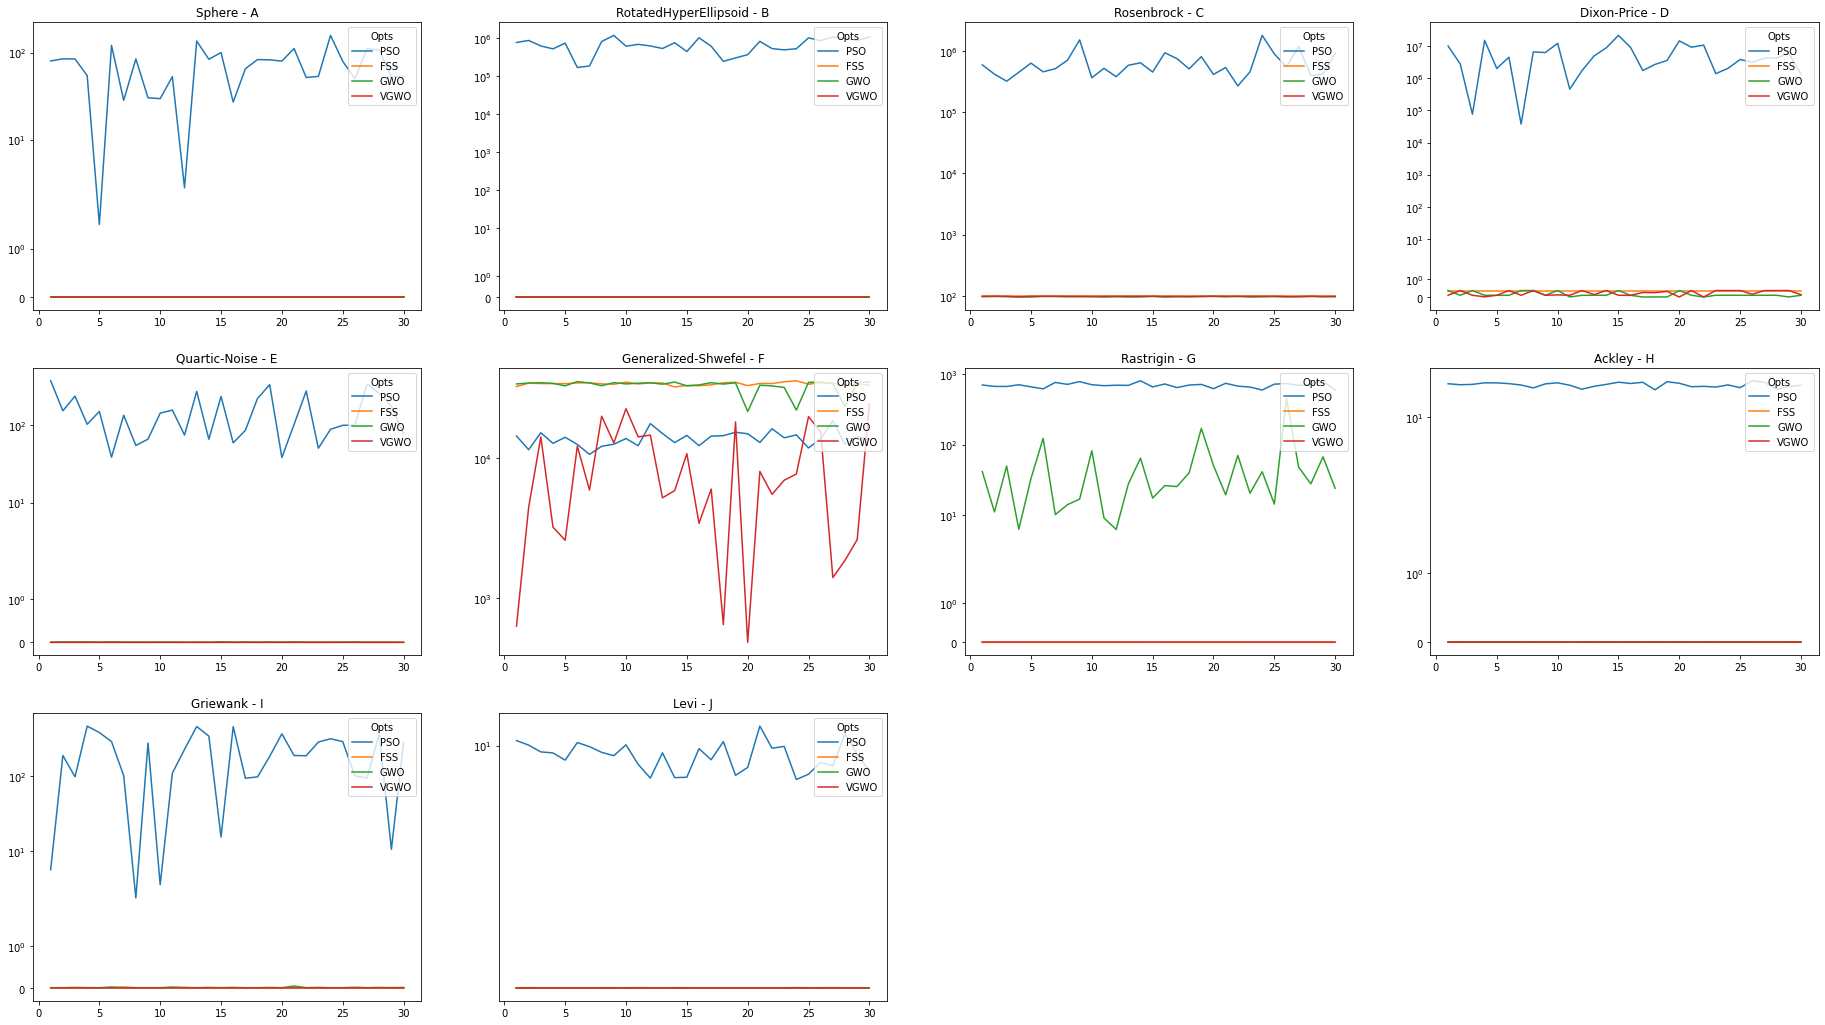

In [4]:
plt.rcParams["figure.figsize"] = (32,18)
tb_dt = {}
for d in results:
  tb_dt[d] = {}
  objective_functions = results[d]['func'].unique().tolist()
  # objective_functions.remove('Levi-13')
  # objective_functions.remove('Perm')
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    tb_dt[d][func] = {}
    plt.subplot(3, 4, i+1)
    for o in opts:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0]
      y = [v if v < 999e+999 else 999e+999 for v in y]
      tb_dt[d][func][o] = y
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      plt.yscale('symlog')
      plt.legend(loc='upper right', title='Opts')
    plt.title(f"{func} - {string.ascii_uppercase[i]}")
  plt.show()

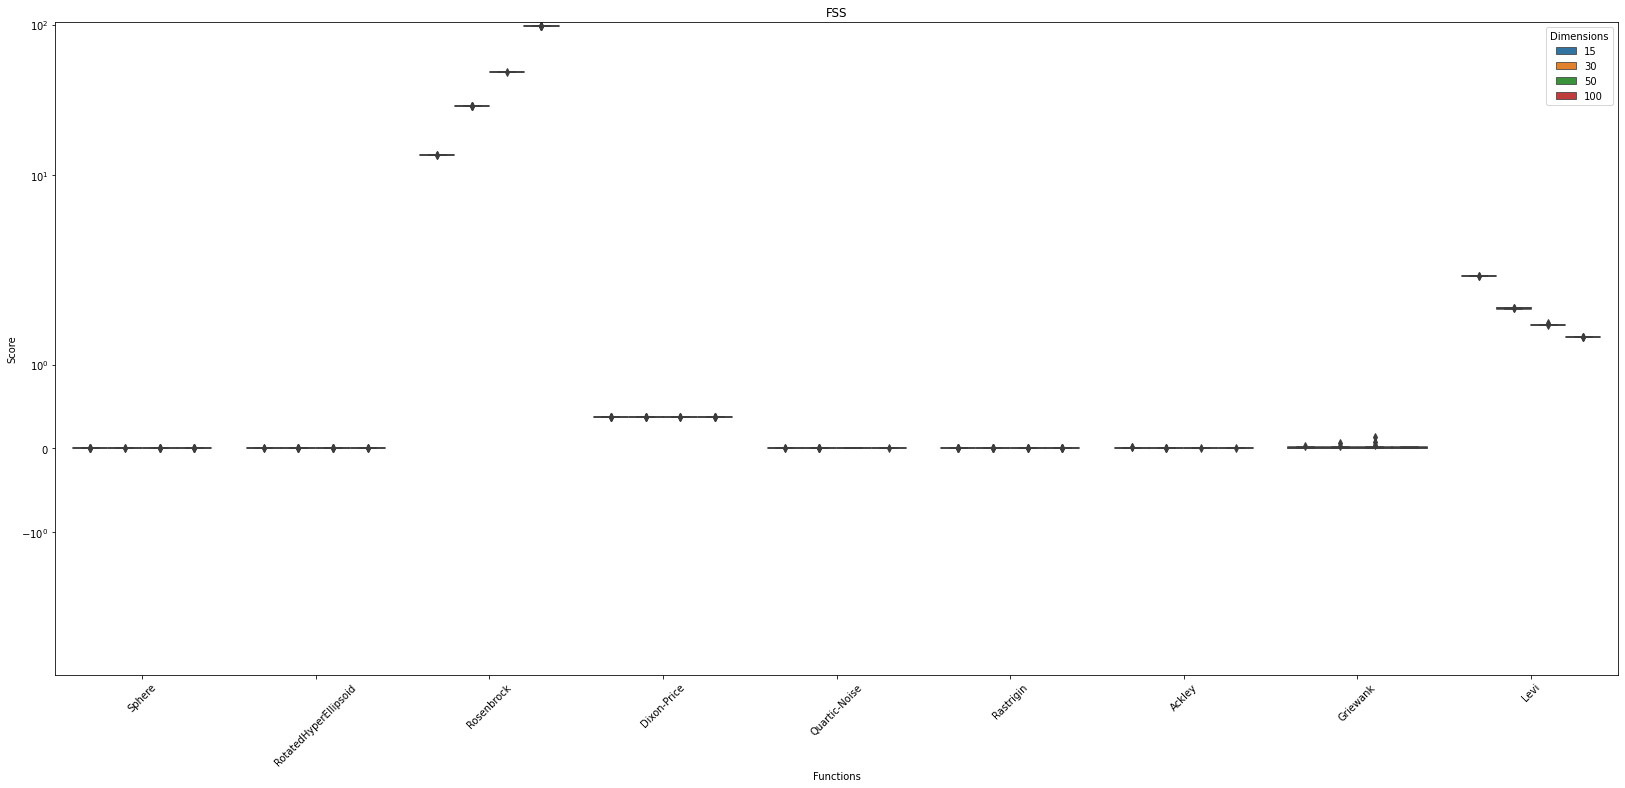

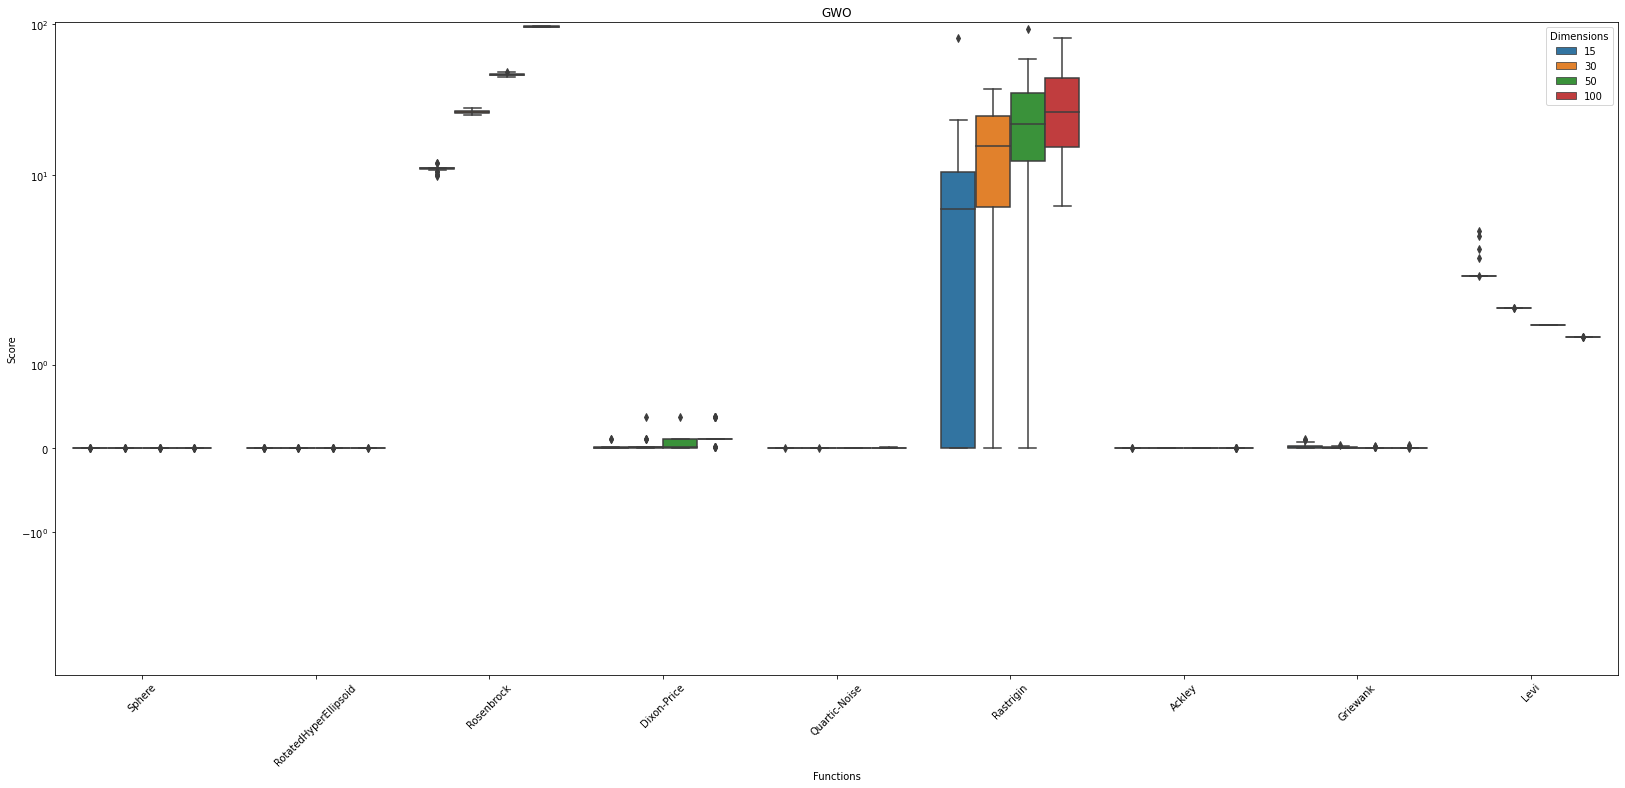

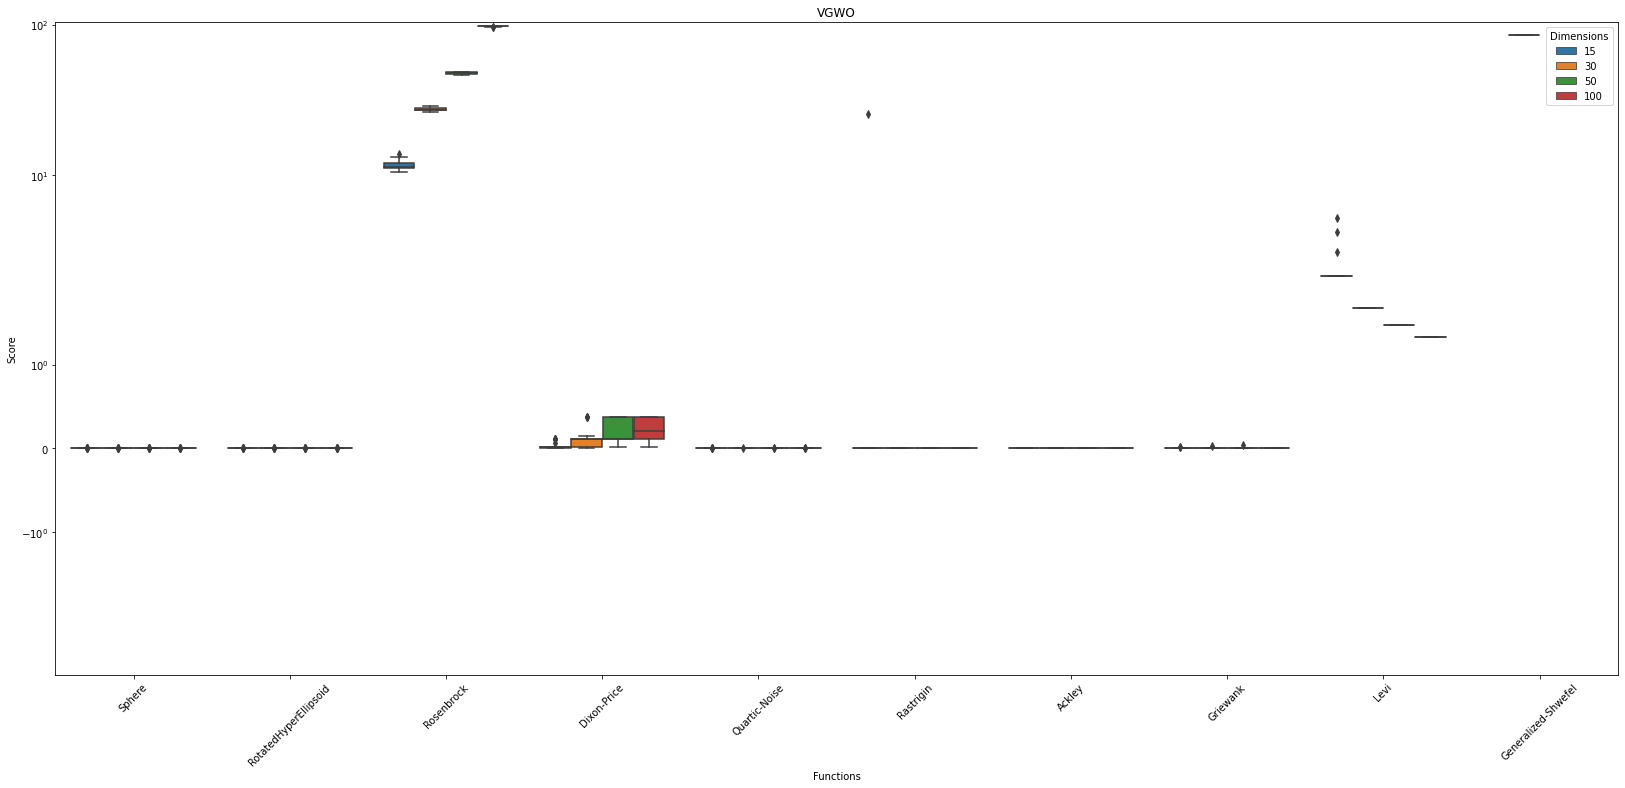

In [5]:
plt.rcParams["figure.figsize"] = (28,12)
for opt in opts[1:]:
  obj_show = []
  for d in results:
    objective_functions = results[d]['func'].unique().tolist()
    # objective_functions.remove('Levi-13')
    # objective_functions.remove('Perm')
    # objective_functions.remove('Perm')
    for func in objective_functions:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == opt].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      scores = res.values.tolist()[0]
      for s in scores:
        obj_show.append({'func': func, 'score': s, 'dim': d})

  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['func', 'score', 'dim'])
  res = res[res["score"] <= 100] # remove outliers
  ax = sns.boxplot(data=res, x='func', y='score', hue="dim")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Functions', ylabel='Score', title=f"{opt}")
  plt.legend(loc='upper right', title='Dimensions')
  plt.yscale('symlog')
  plt.show()

In [6]:
dt_func = []
for d in tb_dt:
  for func in tb_dt[d]:
    if func in ['Perm', 'Levi-13']:
      continue
    print(f"{func} w/ {d} dim")
    opts = list(tb_dt[d][func].keys())
    size_tb = len(tb_dt[d][func]["VGWO"])
    lines = [[tb_dt[d][func][o][i] for o in opts] for i in range(size_tb)]
    dt = pd.DataFrame(data=lines, index=range(1, len(tb_dt[d][func][o])+1), columns=opts)
    dt_describe = dt.describe()
    dt_func.append(dt)

    wil_pso_vgwo = sts.wilcoxon(dt['PSO'].tolist(), dt['VGWO'].tolist())
    wil_fss_vgwo = sts.wilcoxon(dt['FSS'].tolist(), dt['VGWO'].tolist())
    wil_gwo_vgwo = sts.wilcoxon(dt['GWO'].tolist(), dt['VGWO'].tolist())
    print('PSO-VGWO', wil_fss_vgwo)
    print('FSS-VGWO', wil_fss_vgwo)
    print('GWO-VGWO', wil_gwo_vgwo)
    # print(dt.describe())
    display(dt_describe.style.format('{:.3e}').highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))
    print()

    # display(dt)
    display(dt.style.format('{:.3e}').highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))
# dt_func[1].loc[:5].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;')

Sphere w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,9.288e-35,1.293e-07,3.220e-98,6.435e-183
std,2.322e-34,2.642e-07,9.083e-98,0.000e+00
min,1.010e-37,3.603e-11,2.571e-104,7.645e-211
25%,9.949e-37,4.069e-09,3.109e-101,7.689e-198
50%,5.875e-36,9.536e-09,3.705e-100,1.460e-194
75%,5.637e-35,7.836e-08,7.316e-99,4.101e-193
max,1.154e-33,1.103e-06,3.528e-97,1.891e-181


,PSO,FSS,GWO,VGWO
1,3.975e-36,5.853e-07,5.783e-100,1.945e-200
2,1.223e-35,8.369e-08,2.368e-99,1.891e-181
3,6.978e-35,4.353e-09,4.543e-101,1.125e-187
4,4.219e-37,1.006e-10,1.489e-97,1.454e-196
5,8.029e-37,2.288e-07,2.765e-101,5.064e-198
6,6.865e-37,7.637e-09,6.885e-103,1.276e-193
7,2.263e-34,4.507e-09,1.045e-98,2.220e-194
8,4.016e-36,7.801e-09,1.045e-99,1.782e-195
9,3.770e-35,3.118e-08,1.967e-101,1.082e-197
10,5.589e-36,2.199e-07,2.185e-103,1.340e-190


RotatedHyperEllipsoid w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,4.295e+02,1.094e-04,1.160e-98,1.729e-186
std,1.311e+03,4.650e-04,6.288e-98,0.000e+00
min,3.099e-37,1.684e-08,3.354e-106,1.253e-203
25%,1.083e-35,5.706e-07,4.395e-103,1.233e-196
50%,6.726e-35,9.956e-06,4.493e-102,2.961e-194
75%,7.493e-34,4.511e-05,5.664e-101,3.576e-191
max,4.295e+03,2.564e-03,3.445e-97,3.651e-185


,PSO,FSS,GWO,VGWO
1,1.238e-35,3.759e-07,9.579e-102,4.747e-196
2,4.295e+03,1.118e-07,2.224e-102,2.903e-198
3,3.258e-35,5.341e-07,3.791e-102,2.364e-202
4,1.125e-34,2.122e-06,2.509e-104,1.650e-194
5,1.746e-34,9.210e-07,2.887e-102,8.543e-197
6,5.385e-33,4.945e-06,6.380e-101,2.370e-196
7,5.955e-36,1.205e-05,4.370e-102,1.093e-193
8,1.041e-35,9.435e-06,9.531e-101,8.760e-200
9,1.211e-35,1.684e-08,2.394e-100,1.196e-189
10,2.190e-36,3.943e-07,1.427e-101,2.534e-192


Rosenbrock w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
FSS-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
GWO-VGWO WilcoxonResult(statistic=60.0, pvalue=0.0003881114287747714)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,7.529e+02,1.377e+01,1.105e+01,1.166e+01
std,4.111e+03,2.358e-07,4.496e-01,7.138e-01
min,7.368e-05,1.377e+01,9.960e+00,1.053e+01
25%,3.577e-01,1.377e+01,1.105e+01,1.123e+01
50%,1.836e+00,1.377e+01,1.113e+01,1.144e+01
75%,5.421e+00,1.377e+01,1.118e+01,1.210e+01
max,2.252e+04,1.377e+01,1.214e+01,1.387e+01


,PSO,FSS,GWO,VGWO
1,5.421e+00,1.377e+01,1.066e+01,1.211e+01
2,4.812e-01,1.377e+01,1.114e+01,1.091e+01
3,5.421e+00,1.377e+01,1.108e+01,1.151e+01
4,8.034e-02,1.377e+01,1.104e+01,1.122e+01
5,1.666e+00,1.377e+01,1.118e+01,1.136e+01
6,1.992e-01,1.377e+01,1.022e+01,1.139e+01
7,2.228e+00,1.377e+01,1.112e+01,1.213e+01
8,2.048e+00,1.377e+01,1.214e+01,1.387e+01
9,1.451e+00,1.377e+01,1.090e+01,1.168e+01
10,5.421e+00,1.377e+01,1.056e+01,1.199e+01


Dixon-Price w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=98.0, pvalue=0.0056671726914977955)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,2.700e+01,3.750e-01,1.153e-02,2.487e-02
std,3.884e+01,8.640e-08,2.728e-02,3.583e-02
min,6.800e-26,3.750e-01,1.961e-04,1.419e-03
25%,3.732e-20,3.750e-01,9.412e-04,3.758e-03
50%,5.766e-16,3.750e-01,1.588e-03,1.390e-02
75%,8.100e+01,3.750e-01,1.286e-02,1.476e-02
max,8.100e+01,3.750e-01,1.100e-01,1.099e-01


,PSO,FSS,GWO,VGWO
1,1.158e-25,3.750e-01,1.078e-03,1.419e-02
2,2.699e-14,3.750e-01,1.360e-02,1.099e-01
3,2.317e-23,3.750e-01,5.657e-04,2.466e-03
4,8.100e+01,3.750e-01,1.760e-03,1.414e-02
5,1.157e-19,3.750e-01,1.238e-03,1.243e-02
6,8.100e+01,3.750e-01,1.031e-03,1.439e-02
7,8.100e+01,3.750e-01,1.289e-02,1.917e-03
8,3.618e-24,3.750e-01,1.526e-03,1.419e-03
9,6.800e-26,3.750e-01,2.237e-03,1.389e-02
10,8.100e+01,3.750e-01,5.885e-04,3.692e-03


Quartic-Noise w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.826e-01,3.692e-04,1.054e-03,1.824e-05
std,6.814e-01,3.105e-04,6.924e-04,1.830e-05
min,5.543e-04,3.082e-05,2.387e-04,6.417e-07
25%,1.877e-03,1.340e-04,4.731e-04,6.567e-06
50%,3.225e-03,2.804e-04,9.759e-04,1.137e-05
75%,4.526e-03,5.118e-04,1.411e-03,2.290e-05
max,2.689e+00,1.216e-03,3.414e-03,7.081e-05


,PSO,FSS,GWO,VGWO
1,3.038e-03,2.580e-04,1.656e-03,9.623e-06
2,3.696e-03,1.456e-04,9.792e-04,1.729e-05
3,8.589e-03,2.524e-04,1.377e-03,5.033e-06
4,1.290e-02,2.413e-04,3.730e-04,6.417e-07
5,2.554e-03,1.234e-04,1.423e-03,1.109e-06
6,4.128e-03,1.161e-03,5.388e-04,1.800e-05
7,3.910e-03,1.140e-04,3.414e-03,6.593e-06
8,3.173e-03,3.028e-04,6.979e-04,1.084e-05
9,3.903e-03,3.957e-04,4.149e-04,2.358e-06
10,2.782e-03,4.303e-05,1.676e-03,1.190e-05


Generalized-Shwefel w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=44.0, pvalue=0.00010569503498431287)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,5.573e+02,4.062e+03,2.613e+03,1.570e+03
std,3.371e+02,3.399e+02,7.599e+02,7.233e+02
min,1.909e-04,3.013e+03,1.291e+03,2.217e+02
25%,3.553e+02,3.893e+03,2.131e+03,1.088e+03
50%,5.034e+02,4.056e+03,2.663e+03,1.651e+03
75%,6.514e+02,4.300e+03,3.127e+03,1.981e+03
max,1.224e+03,4.703e+03,4.093e+03,3.704e+03


,PSO,FSS,GWO,VGWO
1,4.343e+02,4.050e+03,2.122e+03,2.253e+03
2,3.553e+02,3.690e+03,2.208e+03,2.014e+03
3,1.909e-04,4.298e+03,3.361e+03,2.306e+03
4,2.171e+02,4.703e+03,2.344e+03,1.691e+03
5,6.514e+02,4.306e+03,3.140e+03,1.529e+03
6,1.145e+03,4.200e+03,2.791e+03,1.612e+03
7,6.514e+02,3.747e+03,2.780e+03,3.704e+03
8,4.343e+02,3.892e+03,2.890e+03,1.424e+03
9,4.343e+02,3.750e+03,2.620e+03,1.397e+03
10,6.514e+02,4.341e+03,2.441e+03,2.145e+03


Rastrigin w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=30.0, pvalue=3.1123151153729114e-05)
FSS-VGWO WilcoxonResult(statistic=30.0, pvalue=3.1123151153729114e-05)
GWO-VGWO WilcoxonResult(statistic=24.0, pvalue=0.00019355588228553327)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,2.631e+01,1.818e-04,9.171e+00,8.477e-01
std,1.425e+01,4.689e-04,1.491e+01,4.643e+00
min,7.960e+00,2.548e-09,0.000e+00,0.000e+00
25%,1.617e+01,1.979e-06,2.842e-14,0.000e+00
50%,2.388e+01,1.237e-05,5.951e+00,0.000e+00
75%,3.632e+01,8.366e-05,1.057e+01,0.000e+00
max,6.375e+01,2.428e-03,8.080e+01,2.543e+01


,PSO,FSS,GWO,VGWO
1,8.955e+00,2.428e-03,1.481e+01,0.000e+00
2,7.960e+00,1.875e-06,8.325e+00,0.000e+00
3,4.278e+01,5.677e-05,5.929e+00,0.000e+00
4,3.980e+01,5.492e-04,1.240e+01,0.000e+00
5,1.393e+01,1.127e-04,2.842e-14,2.543e+01
6,1.990e+01,5.610e-07,2.314e+01,0.000e+00
7,1.592e+01,2.939e-08,5.343e+00,0.000e+00
8,2.885e+01,8.421e-05,2.842e-14,0.000e+00
9,1.691e+01,1.096e-05,2.842e-14,0.000e+00
10,2.587e+01,3.332e-04,0.000e+00,0.000e+00


Ackley w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.0144446281440423e-07)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,9.930e-01,1.871e-03,7.668e-15,4.441e-16
std,3.093e+00,2.567e-03,1.470e-15,0.000e+00
min,3.997e-15,2.924e-05,3.997e-15,4.441e-16
25%,7.550e-15,2.502e-04,7.550e-15,4.441e-16
50%,7.550e-15,9.186e-04,7.550e-15,4.441e-16
75%,1.005e+00,2.240e-03,7.550e-15,4.441e-16
max,1.670e+01,1.124e-02,1.465e-14,4.441e-16


,PSO,FSS,GWO,VGWO
1,3.997e-15,1.077e-03,3.997e-15,4.441e-16
2,1.670e+01,3.158e-05,1.465e-14,4.441e-16
3,2.315e+00,1.124e-02,7.550e-15,4.441e-16
4,7.550e-15,2.924e-05,7.550e-15,4.441e-16
5,7.550e-15,3.602e-05,7.550e-15,4.441e-16
6,3.461e+00,5.286e-04,7.550e-15,4.441e-16
7,1.340e+00,6.914e-05,7.550e-15,4.441e-16
8,3.997e-15,4.948e-04,7.550e-15,4.441e-16
9,3.997e-15,1.427e-04,7.550e-15,4.441e-16
10,7.550e-15,3.880e-04,7.550e-15,4.441e-16


Griewank w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=26.0, pvalue=2.1630223983536902e-05)
FSS-VGWO WilcoxonResult(statistic=26.0, pvalue=2.1630223983536902e-05)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=0.0001318338889828333)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,5.276e-02,4.396e-03,2.507e-02,8.247e-04
std,3.212e-02,7.231e-03,2.993e-02,3.189e-03
min,0.000e+00,9.626e-08,0.000e+00,0.000e+00
25%,2.946e-02,3.363e-05,0.000e+00,0.000e+00
50%,5.404e-02,3.533e-04,1.886e-02,0.000e+00
75%,7.555e-02,9.554e-03,3.310e-02,0.000e+00
max,1.228e-01,2.864e-02,1.074e-01,1.452e-02


,PSO,FSS,GWO,VGWO
1,4.666e-02,9.866e-03,8.355e-03,0.000e+00
2,5.403e-02,8.621e-03,3.311e-02,0.000e+00
3,7.127e-02,1.052e-02,2.908e-02,0.000e+00
4,1.228e-01,7.291e-04,1.956e-02,0.000e+00
5,4.178e-02,1.304e-04,0.000e+00,0.000e+00
6,2.946e-02,3.689e-07,0.000e+00,0.000e+00
7,9.078e-02,4.046e-05,2.822e-02,0.000e+00
8,9.089e-02,9.647e-04,5.170e-02,0.000e+00
9,5.405e-02,9.899e-03,3.332e-02,0.000e+00
10,1.232e-02,4.422e-06,2.141e-02,0.000e+00


Levi w/ 15 dim
PSO-VGWO WilcoxonResult(statistic=87.0, pvalue=0.0027652741969916386)
FSS-VGWO WilcoxonResult(statistic=87.0, pvalue=0.0027652741969916386)
GWO-VGWO WilcoxonResult(statistic=83.0, pvalue=0.0012381944609013177)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,3.819e+00,2.160e+00,2.351e+00,2.362e+00
std,1.198e+00,9.746e-04,5.399e-01,6.772e-01
min,2.160e+00,2.160e+00,2.160e+00,2.160e+00
25%,2.997e+00,2.160e+00,2.160e+00,2.160e+00
50%,3.722e+00,2.160e+00,2.160e+00,2.160e+00
75%,4.359e+00,2.160e+00,2.160e+00,2.160e+00
max,7.364e+00,2.165e+00,4.297e+00,5.230e+00


,PSO,FSS,GWO,VGWO
1,4.851e+00,2.160e+00,2.160e+00,2.160e+00
2,4.254e+00,2.160e+00,2.160e+00,2.160e+00
3,4.361e+00,2.160e+00,2.160e+00,2.160e+00
4,3.524e+00,2.160e+00,2.160e+00,2.160e+00
5,4.354e+00,2.160e+00,2.160e+00,2.160e+00
6,2.701e+00,2.161e+00,2.160e+00,2.160e+00
7,3.216e+00,2.160e+00,2.160e+00,2.160e+00
8,4.849e+00,2.160e+00,2.160e+00,2.160e+00
9,3.379e+00,2.160e+00,2.160e+00,2.160e+00
10,3.732e+00,2.160e+00,2.160e+00,2.160e+00


Sphere w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.748e+00,1.998e-08,3.232e-65,3.795e-184
std,6.651e+00,4.523e-08,9.846e-65,0.000e+00
min,1.021e-17,1.039e-13,1.824e-68,2.065e-210
25%,2.134e-16,1.450e-09,9.570e-67,4.579e-195
50%,7.347e-16,6.443e-09,3.407e-66,2.162e-191
75%,1.419e-14,1.830e-08,1.280e-65,3.693e-187
max,2.621e+01,2.251e-07,5.222e-64,7.195e-183


,PSO,FSS,GWO,VGWO
1,1.190e-14,2.251e-07,8.148e-66,4.743e-184
2,6.453e-14,2.229e-08,5.164e-67,1.223e-192
3,5.344e-16,1.199e-11,1.506e-66,3.533e-195
4,1.522e-14,2.520e-09,3.614e-68,5.637e-194
5,2.745e-16,7.522e-10,8.139e-66,1.028e-196
6,1.021e-17,1.941e-11,5.222e-64,1.616e-190
7,3.371e-16,4.570e-09,7.114e-68,1.440e-183
8,1.055e-14,3.243e-08,4.791e-68,1.323e-200
9,1.960e-13,6.658e-10,2.833e-66,5.763e-197
10,2.621e+01,1.781e-09,2.310e-65,5.676e-191


RotatedHyperEllipsoid w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.417e+04,8.448e-05,1.764e-63,7.716e-184
std,1.961e+04,1.699e-04,3.979e-63,0.000e+00
min,1.246e-15,2.690e-09,6.470e-67,1.133e-201
25%,2.264e-13,2.591e-06,3.763e-65,2.027e-191
50%,4.295e+03,1.387e-05,1.991e-64,1.551e-189
75%,2.577e+04,3.995e-05,1.129e-63,1.397e-187
max,6.013e+04,6.819e-04,1.935e-62,1.020e-182


,PSO,FSS,GWO,VGWO
1,1.288e+04,2.690e-09,3.953e-65,7.117e-190
2,1.032e-12,2.405e-06,7.625e-66,6.259e-191
3,8.590e+03,1.186e-05,1.582e-64,2.744e-190
4,5.078e-14,1.588e-05,1.577e-65,8.241e-192
5,9.762e-13,5.613e-07,1.639e-64,5.369e-190
6,4.161e-11,1.523e-07,3.238e-64,1.548e-187
7,3.865e+04,3.952e-04,1.672e-63,2.391e-189
8,6.013e+04,3.418e-05,4.275e-64,2.696e-188
9,1.288e+04,2.370e-05,1.035e-64,3.395e-196
10,3.637e-15,1.035e-07,4.616e-65,1.020e-182


Rosenbrock w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=7.0, pvalue=3.5152372790448263e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,4.632e+04,2.877e+01,2.626e+01,2.750e+01
std,3.620e+04,1.158e-06,6.102e-01,6.572e-01
min,3.263e-01,2.877e+01,2.513e+01,2.650e+01
25%,2.732e+00,2.877e+01,2.600e+01,2.700e+01
50%,5.299e+04,2.877e+01,2.609e+01,2.728e+01
75%,5.300e+04,2.877e+01,2.676e+01,2.789e+01
max,1.060e+05,2.877e+01,2.788e+01,2.874e+01


,PSO,FSS,GWO,VGWO
1,5.142e+04,2.877e+01,2.600e+01,2.788e+01
2,5.300e+04,2.877e+01,2.611e+01,2.705e+01
3,5.142e+04,2.877e+01,2.704e+01,2.713e+01
4,3.263e-01,2.877e+01,2.610e+01,2.789e+01
5,5.300e+04,2.877e+01,2.513e+01,2.874e+01
6,1.836e+00,2.877e+01,2.608e+01,2.794e+01
7,1.801e+00,2.877e+01,2.596e+01,2.698e+01
8,1.049e+05,2.877e+01,2.604e+01,2.763e+01
9,4.061e-01,2.877e+01,2.612e+01,2.747e+01
10,1.030e+05,2.877e+01,2.608e+01,2.821e+01


Dixon-Price w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
FSS-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
GWO-VGWO WilcoxonResult(statistic=66.0, pvalue=0.0006156406207014214)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.899e+04,3.750e-01,3.157e-02,1.014e-01
std,1.038e+05,9.753e-07,7.183e-02,1.035e-01
min,9.583e-11,3.750e-01,1.620e-03,2.202e-03
25%,6.882e-06,3.750e-01,2.671e-03,1.478e-02
50%,2.985e+01,3.750e-01,1.419e-02,1.099e-01
75%,8.100e+01,3.750e-01,1.505e-02,1.100e-01
max,5.684e+05,3.750e-01,3.750e-01,3.750e-01


,PSO,FSS,GWO,VGWO
1,7.856e-10,3.750e-01,1.383e-02,1.099e-01
2,3.105e-09,3.750e-01,1.949e-03,1.099e-01
3,5.349e-04,3.750e-01,1.434e-02,1.101e-01
4,8.100e+01,3.750e-01,1.099e-01,3.308e-03
5,8.100e+01,3.750e-01,1.868e-03,1.414e-02
6,1.186e+01,3.750e-01,2.123e-03,1.391e-02
7,8.100e+01,3.750e-01,1.802e-03,1.099e-01
8,4.000e+01,3.750e-01,1.099e-01,1.417e-01
9,4.147e-10,3.750e-01,1.429e-02,1.647e-02
10,5.580e+00,3.750e-01,1.075e-01,1.101e-01


Quartic-Noise w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
FSS-VGWO WilcoxonResult(statistic=1.0, pvalue=1.9209211049031396e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.548e+00,4.497e-04,2.011e-03,2.052e-05
std,5.352e+00,5.109e-04,1.034e-03,2.184e-05
min,9.178e-03,1.741e-05,4.511e-04,1.028e-07
25%,1.526e-02,1.692e-04,1.364e-03,8.000e-06
50%,2.548e-02,2.543e-04,1.722e-03,1.748e-05
75%,4.018e-02,4.613e-04,2.588e-03,2.588e-05
max,2.686e+01,2.277e-03,5.774e-03,1.144e-04


,PSO,FSS,GWO,VGWO
1,8.324e-02,6.545e-05,1.654e-03,9.146e-06
2,1.486e-02,2.190e-04,2.855e-03,8.222e-06
3,4.029e-02,3.756e-04,2.608e-03,2.059e-05
4,2.684e-02,6.644e-05,1.186e-03,3.888e-05
5,3.073e-02,1.690e-04,1.166e-03,1.358e-05
6,4.219e-02,1.433e-04,1.601e-03,3.807e-05
7,2.355e-02,4.704e-04,2.723e-03,1.945e-05
8,1.468e-02,2.695e-04,1.547e-03,6.386e-06
9,1.704e-02,9.096e-04,4.017e-03,1.880e-05
10,1.891e-02,6.510e-04,9.135e-04,1.147e-05


Generalized-Shwefel w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=37.0, pvalue=5.7924461897570095e-05)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,2.331e+03,9.082e+03,6.158e+03,3.545e+03
std,8.638e+02,6.758e+02,1.762e+03,1.782e+03
min,1.007e+03,6.329e+03,3.803e+03,8.518e+01
25%,1.665e+03,8.713e+03,4.829e+03,2.126e+03
50%,2.162e+03,9.226e+03,5.609e+03,3.612e+03
75%,2.861e+03,9.508e+03,7.903e+03,5.091e+03
max,4.350e+03,9.920e+03,9.117e+03,6.470e+03


,PSO,FSS,GWO,VGWO
1,1.685e+03,9.295e+03,4.537e+03,4.110e+03
2,2.586e+03,9.535e+03,6.543e+03,2.424e+03
3,3.324e+03,9.583e+03,8.619e+03,3.123e+03
4,3.074e+03,9.163e+03,5.629e+03,6.270e+03
5,2.586e+03,8.782e+03,8.912e+03,4.255e+03
6,3.126e+03,8.477e+03,4.907e+03,2.330e+03
7,1.954e+03,6.329e+03,9.109e+03,4.554e+03
8,2.231e+03,9.538e+03,5.429e+03,5.817e+03
9,4.035e+03,9.721e+03,8.192e+03,1.728e+03
10,1.007e+03,8.690e+03,5.603e+03,3.781e+03


Rastrigin w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=5.606116527496013e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.257e+02,5.934e-05,1.608e+01,0.000e+00
std,3.550e+01,1.236e-04,1.105e+01,0.000e+00
min,6.069e+01,2.980e-09,0.000e+00,0.000e+00
25%,9.756e+01,5.749e-07,6.194e+00,0.000e+00
50%,1.255e+02,9.285e-06,1.554e+01,0.000e+00
75%,1.471e+02,3.315e-05,2.488e+01,0.000e+00
max,2.002e+02,5.505e-04,3.746e+01,0.000e+00


,PSO,FSS,GWO,VGWO
1,1.823e+02,1.269e-08,5.684e-14,0.000e+00
2,1.313e+02,2.695e-06,1.460e+01,0.000e+00
3,8.059e+01,4.133e-06,2.073e+01,0.000e+00
4,6.069e+01,5.505e-04,1.502e+01,0.000e+00
5,9.452e+01,2.980e-09,2.098e+01,0.000e+00
6,9.658e+01,9.227e-05,3.746e+01,0.000e+00
7,1.264e+02,7.067e-05,5.000e+00,0.000e+00
8,9.552e+01,7.591e-07,1.743e+01,0.000e+00
9,1.772e+02,5.691e-07,1.189e+01,0.000e+00
10,1.464e+02,1.989e-04,3.573e+01,0.000e+00


Ackley w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.2033227464728908e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,4.102e+00,6.544e-04,1.821e-14,4.441e-16
std,4.024e+00,1.197e-03,3.732e-15,0.000e+00
min,1.002e-07,2.114e-05,1.465e-14,4.441e-16
25%,2.244e+00,1.575e-04,1.465e-14,4.441e-16
50%,2.813e+00,2.733e-04,1.821e-14,4.441e-16
75%,4.297e+00,6.124e-04,2.176e-14,4.441e-16
max,1.694e+01,6.341e-03,2.887e-14,4.441e-16


,PSO,FSS,GWO,VGWO
1,1.456e+01,7.868e-04,1.465e-14,4.441e-16
2,3.403e+00,4.205e-04,1.465e-14,4.441e-16
3,2.580e+00,1.465e-04,1.465e-14,4.441e-16
4,1.502e+00,1.210e-03,2.176e-14,4.441e-16
5,2.580e+00,4.494e-04,2.176e-14,4.441e-16
6,1.437e+01,4.908e-04,2.887e-14,4.441e-16
7,5.090e+00,2.207e-04,1.465e-14,4.441e-16
8,3.628e+00,5.293e-04,1.821e-14,4.441e-16
9,2.408e+00,7.419e-04,2.176e-14,4.441e-16
10,4.423e+00,1.371e-03,1.465e-14,4.441e-16


Griewank w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=29.0, pvalue=2.8434237746031825e-05)
FSS-VGWO WilcoxonResult(statistic=29.0, pvalue=2.8434237746031825e-05)
GWO-VGWO WilcoxonResult(statistic=10.0, pvalue=0.04085984371280629)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,6.087e+00,5.577e-03,6.124e-03,9.748e-04
std,2.299e+01,1.237e-02,9.884e-03,5.339e-03
min,8.216e-15,1.076e-08,0.000e+00,0.000e+00
25%,1.920e-10,4.317e-06,0.000e+00,0.000e+00
50%,1.600e-02,1.644e-04,0.000e+00,0.000e+00
75%,5.521e-02,9.281e-03,1.287e-02,0.000e+00
max,9.089e+01,6.295e-02,3.746e-02,2.924e-02


,PSO,FSS,GWO,VGWO
1,6.735e-13,1.076e-08,0.000e+00,0.000e+00
2,5.651e-02,3.200e-04,0.000e+00,0.000e+00
3,2.457e-02,9.875e-03,0.000e+00,0.000e+00
4,7.396e-03,7.183e-06,0.000e+00,2.924e-02
5,1.477e-02,2.590e-02,0.000e+00,0.000e+00
6,1.232e-02,6.295e-02,0.000e+00,0.000e+00
7,9.040e+01,1.012e-02,1.513e-02,0.000e+00
8,1.477e-02,4.228e-03,0.000e+00,0.000e+00
9,3.063e-13,2.361e-04,1.019e-02,0.000e+00
10,8.831e-02,2.235e-06,2.251e-02,0.000e+00


Levi w/ 30 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.044214691755096e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,4.590e+00,1.670e+00,1.669e+00,1.669e+00
std,1.224e+00,9.065e-04,4.225e-16,4.517e-16
min,2.947e+00,1.669e+00,1.669e+00,1.669e+00
25%,3.599e+00,1.669e+00,1.669e+00,1.669e+00
50%,4.199e+00,1.669e+00,1.669e+00,1.669e+00
75%,5.459e+00,1.670e+00,1.669e+00,1.669e+00
max,7.294e+00,1.674e+00,1.669e+00,1.669e+00


,PSO,FSS,GWO,VGWO
1,3.346e+00,1.669e+00,1.669e+00,1.669e+00
2,3.527e+00,1.669e+00,1.669e+00,1.669e+00
3,3.645e+00,1.670e+00,1.669e+00,1.669e+00
4,4.156e+00,1.669e+00,1.669e+00,1.669e+00
5,5.487e+00,1.669e+00,1.669e+00,1.669e+00
6,3.370e+00,1.669e+00,1.669e+00,1.669e+00
7,2.947e+00,1.670e+00,1.669e+00,1.669e+00
8,3.583e+00,1.669e+00,1.669e+00,1.669e+00
9,5.376e+00,1.671e+00,1.669e+00,1.669e+00
10,7.294e+00,1.669e+00,1.669e+00,1.669e+00


Sphere w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.748e+01,3.420e-08,4.728e-49,2.598e-182
std,1.732e+01,8.837e-08,1.315e-48,0.000e+00
min,6.425e-07,7.407e-12,1.530e-51,1.411e-201
25%,2.462e-05,6.766e-10,1.926e-50,4.512e-192
50%,2.621e+01,5.681e-09,4.019e-50,1.039e-188
75%,2.621e+01,1.661e-08,2.294e-49,1.547e-186
max,5.243e+01,4.566e-07,6.995e-48,4.667e-181


,PSO,FSS,GWO,VGWO
1,3.628e-06,1.448e-08,4.880e-50,1.530e-186
2,1.372e-06,1.332e-10,1.551e-49,4.245e-192
3,2.622e+01,7.571e-09,1.560e-51,9.870e-189
4,2.621e+01,7.407e-12,7.458e-49,4.847e-187
5,4.963e-04,1.801e-10,1.119e-50,7.621e-189
6,2.345e-05,2.224e-09,1.835e-49,1.668e-189
7,2.621e+01,3.807e-09,1.927e-50,1.092e-188
8,1.476e-05,6.710e-08,1.618e-48,3.366e-191
9,5.243e+01,8.941e-09,1.123e-50,1.806e-194
10,2.621e+01,4.566e-07,3.965e-50,5.311e-192


RotatedHyperEllipsoid w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,6.944e+04,1.135e-04,3.775e-46,9.098e-181
std,5.616e+04,2.445e-04,6.476e-46,0.000e+00
min,7.369e-04,3.719e-08,2.451e-48,1.160e-198
25%,2.255e+04,2.567e-06,1.619e-47,5.932e-191
50%,6.013e+04,8.450e-06,6.964e-47,2.704e-188
75%,1.009e+05,5.326e-05,4.106e-46,4.221e-185
max,1.890e+05,8.984e-04,2.647e-45,2.134e-179


,PSO,FSS,GWO,VGWO
1,1.460e+05,9.737e-08,1.479e-45,1.183e-184
2,6.998e-03,4.102e-05,2.647e-45,3.138e-185
3,1.288e+04,1.391e-07,2.029e-47,8.472e-190
4,7.369e-04,1.110e-05,8.895e-48,3.804e-189
5,1.074e+05,3.719e-08,1.440e-45,4.239e-198
6,5.154e+04,6.033e-05,1.420e-46,7.612e-195
7,7.731e+04,3.088e-06,8.153e-47,4.271e-191
8,1.632e+05,9.809e-06,1.642e-46,1.646e-187
9,2.147e+04,5.887e-04,2.451e-48,1.168e-183
10,8.590e+03,9.518e-07,1.299e-46,7.859e-190


Rosenbrock w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=3.0, pvalue=2.3534209951215346e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.707e+05,4.877e+01,4.661e+01,4.780e+01
std,7.868e+04,2.017e-07,7.654e-01,6.296e-01
min,4.670e+04,4.877e+01,4.499e+01,4.657e+01
25%,1.060e+05,4.877e+01,4.602e+01,4.732e+01
50%,1.588e+05,4.877e+01,4.652e+01,4.777e+01
75%,2.103e+05,4.877e+01,4.697e+01,4.837e+01
max,4.168e+05,4.877e+01,4.847e+01,4.859e+01


,PSO,FSS,GWO,VGWO
1,1.060e+05,4.877e+01,4.581e+01,4.774e+01
2,3.163e+05,4.877e+01,4.601e+01,4.853e+01
3,2.390e+05,4.877e+01,4.699e+01,4.791e+01
4,1.590e+05,4.877e+01,4.603e+01,4.805e+01
5,1.582e+05,4.877e+01,4.665e+01,4.838e+01
6,1.460e+05,4.877e+01,4.698e+01,4.691e+01
7,4.670e+04,4.877e+01,4.646e+01,4.836e+01
8,1.859e+05,4.877e+01,4.654e+01,4.717e+01
9,1.560e+05,4.877e+01,4.597e+01,4.728e+01
10,1.060e+05,4.877e+01,4.603e+01,4.781e+01


Dixon-Price w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=28.0, pvalue=2.5967125848447383e-05)
FSS-VGWO WilcoxonResult(statistic=28.0, pvalue=2.5967125848447383e-05)
GWO-VGWO WilcoxonResult(statistic=43.0, pvalue=9.711048976071607e-05)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,2.579e+05,3.750e-01,4.873e-02,1.934e-01
std,5.189e+05,2.146e-07,7.637e-02,1.340e-01
min,1.468e-02,3.750e-01,2.534e-03,1.397e-02
25%,6.599e+01,3.750e-01,4.046e-03,1.099e-01
50%,8.100e+01,3.750e-01,1.500e-02,1.102e-01
75%,3.344e+05,3.750e-01,1.099e-01,3.726e-01
max,1.939e+06,3.750e-01,3.750e-01,3.750e-01


,PSO,FSS,GWO,VGWO
1,8.100e+01,3.750e-01,3.750e-01,1.104e-01
2,1.068e+00,3.750e-01,3.834e-03,1.099e-01
3,3.858e+05,3.750e-01,1.102e-01,1.101e-01
4,8.101e+01,3.750e-01,1.103e-01,1.099e-01
5,7.925e+01,3.750e-01,1.548e-02,3.750e-01
6,2.831e+01,3.750e-01,1.102e-01,1.099e-01
7,8.861e+05,3.750e-01,1.435e-02,1.099e-01
8,8.100e+01,3.750e-01,1.465e-02,3.750e-01
9,5.684e+05,3.750e-01,1.102e-01,3.750e-01
10,1.939e+06,3.750e-01,1.310e-02,3.750e-01


Quartic-Noise w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.712e+01,3.716e-04,3.616e-03,2.264e-05
std,1.753e+01,2.337e-04,1.766e-03,2.186e-05
min,3.686e-02,2.134e-05,1.312e-03,1.767e-09
25%,2.082e-01,1.911e-04,2.279e-03,5.484e-06
50%,1.354e+01,3.267e-04,3.317e-03,1.803e-05
75%,2.896e+01,4.939e-04,4.644e-03,3.116e-05
max,5.384e+01,8.964e-04,7.593e-03,8.352e-05


,PSO,FSS,GWO,VGWO
1,3.505e+01,1.598e-04,4.972e-03,5.264e-06
2,2.750e+00,8.964e-04,2.262e-03,7.443e-05
3,3.499e+01,7.640e-04,3.223e-03,4.549e-06
4,4.300e+01,2.675e-04,7.593e-03,1.395e-05
5,1.228e-01,4.460e-04,3.430e-03,1.767e-09
6,1.356e+01,2.119e-04,4.653e-03,2.420e-05
7,1.953e-01,2.653e-04,3.233e-03,1.341e-05
8,1.623e+01,3.644e-04,2.460e-03,6.486e-05
9,2.388e-01,2.689e-04,1.416e-03,6.629e-07
10,5.384e+01,7.321e-04,2.901e-03,2.670e-05


Generalized-Shwefel w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=4.0, pvalue=2.603328389538926e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,5.005e+03,1.629e+04,1.225e+04,5.700e+03
std,1.075e+03,6.584e+02,3.173e+03,3.198e+03
min,3.080e+03,1.480e+04,6.865e+03,2.964e+02
25%,4.034e+03,1.599e+04,9.481e+03,3.353e+03
50%,5.122e+03,1.636e+04,1.081e+04,5.809e+03
75%,5.839e+03,1.671e+04,1.553e+04,8.235e+03
max,6.621e+03,1.754e+04,1.654e+04,1.253e+04


,PSO,FSS,GWO,VGWO
1,5.555e+03,1.480e+04,9.476e+03,3.857e+03
2,5.989e+03,1.543e+04,8.927e+03,5.583e+03
3,6.219e+03,1.664e+04,9.237e+03,1.059e+04
4,4.903e+03,1.599e+04,1.416e+04,3.533e+03
5,3.080e+03,1.724e+04,1.654e+04,6.832e+03
6,3.864e+03,1.637e+04,1.095e+04,3.981e+03
7,4.192e+03,1.607e+04,1.595e+04,5.936e+02
8,5.155e+03,1.640e+04,1.016e+04,2.459e+03
9,3.734e+03,1.622e+04,6.865e+03,3.293e+03
10,5.804e+03,1.506e+04,1.509e+04,6.268e+03


Rastrigin w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,2.577e+02,7.387e-05,2.814e+01,0.000e+00
std,4.682e+01,2.529e-04,2.342e+01,0.000e+00
min,1.632e+02,5.173e-12,1.137e-13,0.000e+00
25%,2.287e+02,4.036e-07,1.273e+01,0.000e+00
50%,2.633e+02,5.476e-06,2.295e+01,0.000e+00
75%,2.832e+02,2.951e-05,3.678e+01,0.000e+00
max,3.434e+02,1.378e-03,1.024e+02,0.000e+00


,PSO,FSS,GWO,VGWO
1,2.150e+02,3.204e-05,4.242e+01,0.000e+00
2,2.309e+02,1.336e-07,5.931e+01,0.000e+00
3,2.818e+02,3.368e-05,1.053e+01,0.000e+00
4,2.769e+02,1.620e-06,2.590e+01,0.000e+00
5,2.590e+02,7.822e-08,9.262e+01,0.000e+00
6,2.488e+02,1.388e-05,7.555e+00,0.000e+00
7,2.939e+02,7.043e-06,3.341e+01,0.000e+00
8,2.788e+02,6.353e-06,3.739e+01,0.000e+00
9,1.722e+02,1.641e-07,1.249e+01,0.000e+00
10,2.778e+02,1.689e-04,3.967e+00,0.000e+00


Ackley w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.2640298823827336e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.160e+01,5.493e-04,3.337e-14,4.441e-16
std,4.525e+00,7.980e-04,4.165e-15,0.000e+00
min,3.763e+00,2.251e-06,2.887e-14,4.441e-16
25%,6.953e+00,7.996e-05,2.887e-14,4.441e-16
50%,1.359e+01,1.858e-04,3.242e-14,4.441e-16
75%,1.563e+01,7.610e-04,3.864e-14,4.441e-16
max,1.688e+01,3.884e-03,3.952e-14,4.441e-16


,PSO,FSS,GWO,VGWO
1,8.964e+00,3.884e-03,3.952e-14,4.441e-16
2,1.632e+01,7.273e-04,3.952e-14,4.441e-16
3,1.554e+01,7.882e-05,3.952e-14,4.441e-16
4,1.632e+01,5.271e-04,3.242e-14,4.441e-16
5,1.438e+01,2.251e-06,2.887e-14,4.441e-16
6,1.631e+01,1.700e-04,3.952e-14,4.441e-16
7,1.341e+01,8.823e-04,2.887e-14,4.441e-16
8,8.254e+00,5.088e-05,2.887e-14,4.441e-16
9,1.688e+01,1.759e-04,2.887e-14,4.441e-16
10,4.976e+00,1.928e-04,3.242e-14,4.441e-16


Griewank w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=27.0, pvalue=2.370447702550485e-05)
FSS-VGWO WilcoxonResult(statistic=27.0, pvalue=2.370447702550485e-05)
GWO-VGWO WilcoxonResult(statistic=7.0, pvalue=0.23672357063785732)


/usr/local/lib/python3.8/dist-packages/scipy/stats/morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,3.934e+01,1.066e-02,3.790e-03,1.136e-03
std,5.136e+01,2.763e-02,8.363e-03,6.223e-03
min,1.188e-03,5.544e-08,0.000e+00,0.000e+00
25%,1.154e-01,3.509e-05,0.000e+00,0.000e+00
50%,4.073e-01,6.497e-04,0.000e+00,0.000e+00
75%,9.028e+01,9.891e-03,0.000e+00,0.000e+00
max,1.809e+02,1.335e-01,3.228e-02,3.409e-02


,PSO,FSS,GWO,VGWO
1,9.028e+01,9.898e-03,0.000e+00,0.000e+00
2,1.809e+02,2.619e-04,0.000e+00,0.000e+00
3,9.541e-03,4.242e-03,0.000e+00,0.000e+00
4,1.421e-01,1.569e-03,0.000e+00,0.000e+00
5,9.017e+01,8.533e-04,3.228e-02,0.000e+00
6,1.395e-01,4.700e-06,1.112e-02,0.000e+00
7,1.188e-03,1.469e-07,0.000e+00,0.000e+00
8,9.042e-02,1.062e-04,0.000e+00,0.000e+00
9,2.382e-01,1.335e-01,0.000e+00,0.000e+00
10,2.964e-02,3.631e-02,0.000e+00,0.000e+00


Levi w/ 50 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.1366311144088478e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,6.210e+00,1.474e+00,1.473e+00,1.473e+00
std,1.049e+00,3.168e-03,7.985e-16,4.517e-16
min,4.046e+00,1.473e+00,1.473e+00,1.473e+00
25%,5.539e+00,1.473e+00,1.473e+00,1.473e+00
50%,6.218e+00,1.473e+00,1.473e+00,1.473e+00
75%,7.065e+00,1.473e+00,1.473e+00,1.473e+00
max,8.609e+00,1.490e+00,1.473e+00,1.473e+00


,PSO,FSS,GWO,VGWO
1,7.353e+00,1.490e+00,1.473e+00,1.473e+00
2,7.336e+00,1.474e+00,1.473e+00,1.473e+00
3,6.775e+00,1.473e+00,1.473e+00,1.473e+00
4,7.021e+00,1.473e+00,1.473e+00,1.473e+00
5,6.197e+00,1.473e+00,1.473e+00,1.473e+00
6,5.627e+00,1.473e+00,1.473e+00,1.473e+00
7,6.842e+00,1.473e+00,1.473e+00,1.473e+00
8,7.098e+00,1.473e+00,1.473e+00,1.473e+00
9,6.078e+00,1.473e+00,1.473e+00,1.473e+00
10,8.609e+00,1.473e+00,1.473e+00,1.473e+00


Sphere w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,7.124e+01,1.391e-07,3.788e-34,3.229e-181
std,3.704e+01,4.146e-07,4.946e-34,0.000e+00
min,1.502e+00,5.033e-11,1.138e-35,2.239e-201
25%,5.196e+01,1.116e-08,7.468e-35,4.201e-193
50%,7.956e+01,2.631e-08,1.803e-34,6.790e-190
75%,8.465e+01,5.969e-08,4.500e-34,2.301e-184
max,1.574e+02,2.266e-06,1.830e-33,9.314e-180


,PSO,FSS,GWO,VGWO
1,8.000e+01,3.088e-08,2.068e-34,1.462e-183
2,8.468e+01,2.175e-08,2.836e-34,1.023e-194
3,8.441e+01,5.290e-11,1.155e-33,1.697e-196
4,5.437e+01,8.126e-09,4.832e-34,2.339e-188
5,1.502e+00,1.502e-08,7.120e-34,3.063e-184
6,1.209e+02,5.379e-09,1.138e-35,1.217e-191
7,2.824e+01,4.143e-08,1.645e-34,1.175e-189
8,8.453e+01,5.894e-08,1.344e-34,9.017e-193
9,3.017e+01,7.497e-09,3.998e-35,2.279e-188
10,2.953e+01,2.175e-08,1.250e-35,2.844e-181


RotatedHyperEllipsoid w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,6.674e+05,2.116e-04,1.452e-30,1.044e-174
std,2.696e+05,5.742e-04,2.251e-30,0.000e+00
min,1.672e+05,1.992e-10,3.948e-32,3.159e-197
25%,5.154e+05,6.013e-06,1.677e-31,3.546e-188
50%,6.460e+05,3.831e-05,4.973e-31,2.489e-185
75%,8.538e+05,1.065e-04,1.947e-30,5.167e-180
max,1.162e+06,2.959e-03,9.567e-30,2.401e-173


,PSO,FSS,GWO,VGWO
1,7.576e+05,3.575e-05,1.139e-30,2.953e-176
2,8.577e+05,1.992e-10,1.619e-31,4.390e-179
3,6.136e+05,2.785e-05,2.920e-30,4.013e-181
4,5.147e+05,1.231e-06,3.333e-31,1.215e-177
5,7.279e+05,7.517e-04,2.154e-30,3.857e-185
6,1.672e+05,4.489e-07,1.133e-31,3.525e-179
7,1.823e+05,2.248e-04,1.343e-31,1.805e-193
8,8.047e+05,5.433e-06,1.851e-31,5.425e-188
9,1.162e+06,7.236e-05,2.631e-30,2.812e-183
10,6.031e+05,1.599e-05,8.091e-32,7.277e-174


Rosenbrock w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=45.0, pvalue=0.0001149921754357011)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,6.419e+05,9.877e+01,9.701e+01,9.786e+01
std,3.436e+05,9.169e-06,8.536e-01,4.487e-01
min,2.675e+05,9.877e+01,9.571e+01,9.650e+01
25%,4.252e+05,9.877e+01,9.669e+01,9.770e+01
50%,5.250e+05,9.877e+01,9.676e+01,9.801e+01
75%,7.339e+05,9.877e+01,9.787e+01,9.819e+01
max,1.783e+06,9.877e+01,9.822e+01,9.830e+01


,PSO,FSS,GWO,VGWO
1,5.899e+05,9.877e+01,9.753e+01,9.765e+01
2,4.153e+05,9.877e+01,9.818e+01,9.812e+01
3,3.188e+05,9.877e+01,9.749e+01,9.771e+01
4,4.464e+05,9.877e+01,9.589e+01,9.650e+01
5,6.288e+05,9.877e+01,9.584e+01,9.820e+01
6,4.534e+05,9.877e+01,9.821e+01,9.799e+01
7,5.108e+05,9.877e+01,9.801e+01,9.803e+01
8,6.997e+05,9.877e+01,9.675e+01,9.809e+01
9,1.504e+06,9.877e+01,9.675e+01,9.803e+01
10,3.629e+05,9.877e+01,9.680e+01,9.791e+01


Dixon-Price w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=77.0, pvalue=0.0013820358574399946)
FSS-VGWO WilcoxonResult(statistic=77.0, pvalue=0.0013820358574399946)
GWO-VGWO WilcoxonResult(statistic=148.0, pvalue=0.08220646595099283)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,5.793e+06,3.750e-01,1.531e-01,2.294e-01
std,5.090e+06,8.491e-08,1.298e-01,1.365e-01
min,3.746e+04,3.750e-01,1.238e-02,1.414e-02
25%,2.007e+06,3.750e-01,1.093e-01,1.100e-01
50%,4.201e+06,3.750e-01,1.104e-01,2.123e-01
75%,8.949e+06,3.750e-01,1.109e-01,3.750e-01
max,2.135e+07,3.750e-01,3.750e-01,3.750e-01


,PSO,FSS,GWO,VGWO
1,1.000e+07,3.750e-01,3.750e-01,1.120e-01
2,2.745e+06,3.750e-01,1.101e-01,3.750e-01
3,7.562e+04,3.750e-01,3.750e-01,1.099e-01
4,1.497e+07,3.750e-01,1.098e-01,2.357e-02
5,2.002e+06,3.750e-01,1.104e-01,1.101e-01
6,4.492e+06,3.750e-01,1.098e-01,3.750e-01
7,3.746e+04,3.750e-01,3.750e-01,1.099e-01
8,6.509e+06,3.750e-01,3.750e-01,3.750e-01
9,6.283e+06,3.750e-01,1.109e-01,1.099e-01
10,1.212e+07,3.750e-01,3.750e-01,1.324e-01


Quartic-Noise w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.530e+02,3.599e-04,6.767e-03,1.552e-05
std,9.872e+01,3.097e-04,3.184e-03,2.114e-05
min,3.829e+01,2.117e-05,2.343e-03,5.773e-07
25%,7.549e+01,1.409e-04,4.480e-03,4.730e-06
50%,1.191e+02,2.754e-04,6.187e-03,6.573e-06
75%,2.333e+02,5.109e-04,8.928e-03,1.818e-05
max,3.776e+02,1.374e-03,1.374e-02,9.694e-05


,PSO,FSS,GWO,VGWO
1,3.776e+02,1.411e-04,3.062e-03,1.288e-05
2,1.542e+02,2.175e-04,9.950e-03,2.726e-05
3,2.384e+02,6.767e-04,9.222e-03,1.431e-06
4,1.032e+02,3.484e-04,1.127e-02,4.621e-06
5,1.512e+02,3.699e-04,4.418e-03,9.694e-05
6,3.863e+01,3.972e-04,1.310e-02,6.257e-06
7,1.350e+02,4.494e-04,6.349e-03,2.226e-05
8,5.485e+01,2.117e-05,7.064e-03,5.773e-07
9,6.627e+01,1.409e-04,6.183e-03,3.925e-05
10,1.437e+02,7.988e-04,6.198e-03,5.060e-06


Generalized-Shwefel w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.380e+04,3.378e+04,3.269e+04,9.016e+03
std,1.717e+03,7.907e+02,3.641e+03,7.025e+03
min,1.059e+04,3.208e+04,2.143e+04,4.833e+02
25%,1.251e+04,3.328e+04,3.280e+04,3.260e+03
50%,1.383e+04,3.389e+04,3.393e+04,6.464e+03
75%,1.457e+04,3.430e+04,3.439e+04,1.413e+04
max,1.845e+04,3.552e+04,3.502e+04,2.435e+04


,PSO,FSS,GWO,VGWO
1,1.434e+04,3.229e+04,3.370e+04,6.309e+02
2,1.144e+04,3.411e+04,3.420e+04,4.433e+03
3,1.512e+04,3.392e+04,3.436e+04,1.412e+04
4,1.270e+04,3.386e+04,3.402e+04,3.208e+03
5,1.404e+04,3.387e+04,3.267e+04,2.587e+03
6,1.247e+04,3.430e+04,3.502e+04,1.214e+04
7,1.059e+04,3.434e+04,3.427e+04,5.899e+03
8,1.211e+04,3.375e+04,3.273e+04,1.983e+04
9,1.252e+04,3.353e+04,3.444e+04,1.280e+04
10,1.374e+04,3.472e+04,3.372e+04,2.243e+04


Rastrigin w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,6.947e+02,3.095e-05,5.338e+01,0.000e+00
std,5.326e+01,5.540e-05,8.301e+01,0.000e+00
min,5.926e+02,6.708e-12,6.217e+00,0.000e+00
25%,6.614e+02,6.278e-07,1.690e+01,0.000e+00
50%,6.971e+02,2.860e-06,2.753e+01,0.000e+00
75%,7.204e+02,3.105e-05,5.001e+01,0.000e+00
max,8.049e+02,2.162e-04,4.503e+02,0.000e+00


,PSO,FSS,GWO,VGWO
1,7.007e+02,6.708e-12,4.121e+01,0.000e+00
2,6.689e+02,1.506e-05,1.104e+01,0.000e+00
3,6.677e+02,1.176e-04,4.949e+01,0.000e+00
4,7.058e+02,9.724e-07,6.264e+00,0.000e+00
5,6.593e+02,2.739e-06,3.284e+01,0.000e+00
6,6.176e+02,1.201e-06,1.223e+02,0.000e+00
7,7.620e+02,1.533e-05,1.011e+01,0.000e+00
8,7.147e+02,5.162e-05,1.398e+01,0.000e+00
9,7.826e+02,2.196e-07,1.675e+01,0.000e+00
10,7.069e+02,3.280e-05,8.156e+01,0.000e+00


Ackley w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.1746865943331012e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,1.804e+01,2.252e-04,9.838e-14,4.441e-16
std,7.869e-01,2.156e-04,8.328e-15,0.000e+00
min,1.646e+01,9.073e-06,7.860e-14,4.441e-16
25%,1.749e+01,5.252e-05,9.281e-14,4.441e-16
50%,1.813e+01,1.504e-04,9.992e-14,4.441e-16
75%,1.867e+01,3.781e-04,9.992e-14,4.441e-16
max,1.945e+01,9.051e-04,1.106e-13,4.441e-16


,PSO,FSS,GWO,VGWO
1,1.841e+01,4.710e-04,1.106e-13,4.441e-16
2,1.807e+01,2.504e-04,8.571e-14,4.441e-16
3,1.819e+01,5.010e-04,9.281e-14,4.441e-16
4,1.872e+01,1.375e-04,9.992e-14,4.441e-16
5,1.871e+01,8.263e-05,1.106e-13,4.441e-16
6,1.845e+01,1.900e-04,1.070e-13,4.441e-16
7,1.798e+01,2.389e-05,8.571e-14,4.441e-16
8,1.705e+01,1.440e-04,9.992e-14,4.441e-16
9,1.837e+01,5.312e-05,9.992e-14,4.441e-16
10,1.872e+01,2.125e-05,9.992e-14,4.441e-16


Griewank w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=0.06788915486182899)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,2.070e+02,4.091e-03,2.507e-03,0.000e+00
std,1.437e+02,5.144e-03,8.458e-03,0.000e+00
min,2.405e+00,2.535e-07,0.000e+00,0.000e+00
25%,9.711e+01,3.877e-05,0.000e+00,0.000e+00
50%,1.866e+02,1.108e-03,0.000e+00,0.000e+00
75%,3.048e+02,9.867e-03,0.000e+00,0.000e+00
max,4.582e+02,1.584e-02,4.094e-02,0.000e+00


,PSO,FSS,GWO,VGWO
1,5.692e+00,3.867e-05,0.000e+00,0.000e+00
2,1.867e+02,1.013e-05,0.000e+00,0.000e+00
3,9.735e+01,1.004e-02,0.000e+00,0.000e+00
4,4.582e+02,3.026e-03,0.000e+00,0.000e+00
5,3.764e+02,1.945e-05,0.000e+00,0.000e+00
6,2.852e+02,5.397e-04,1.718e-02,0.000e+00
7,1.010e+02,1.584e-02,0.000e+00,0.000e+00
8,2.405e+00,1.394e-03,0.000e+00,0.000e+00
9,2.725e+02,1.885e-06,0.000e+00,0.000e+00
10,3.610e+00,1.137e-04,0.000e+00,0.000e+00


Levi w/ 100 dim
PSO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
FSS-VGWO WilcoxonResult(statistic=0.0, pvalue=1.7343976283205784e-06)
GWO-VGWO WilcoxonResult(statistic=0.0, pvalue=1.454231848027314e-06)


,PSO,FSS,GWO,VGWO
count,3.000e+01,3.000e+01,3.000e+01,3.000e+01
mean,9.025e+00,1.326e+00,1.325e+00,1.325e+00
std,1.305e+00,4.592e-04,1.163e-15,4.517e-16
min,7.067e+00,1.325e+00,1.325e+00,1.325e+00
25%,8.030e+00,1.325e+00,1.325e+00,1.325e+00
50%,9.202e+00,1.325e+00,1.325e+00,1.325e+00
75%,9.905e+00,1.326e+00,1.325e+00,1.325e+00
max,1.220e+01,1.327e+00,1.325e+00,1.325e+00


,PSO,FSS,GWO,VGWO
1,1.052e+01,1.325e+00,1.325e+00,1.325e+00
2,1.004e+01,1.326e+00,1.325e+00,1.325e+00
3,9.371e+00,1.325e+00,1.325e+00,1.325e+00
4,9.272e+00,1.325e+00,1.325e+00,1.325e+00
5,8.618e+00,1.325e+00,1.325e+00,1.325e+00
6,1.031e+01,1.326e+00,1.325e+00,1.325e+00
7,9.890e+00,1.325e+00,1.325e+00,1.325e+00
8,9.326e+00,1.326e+00,1.325e+00,1.325e+00
9,9.018e+00,1.326e+00,1.325e+00,1.325e+00
10,1.007e+01,1.325e+00,1.325e+00,1.325e+00


Here we can see the variation of score in each algoritm that even without the outliers show the big score in PSO for the objective functions.

[Text(0, 0.5, 'Score'), Text(0.5, 0, 'Optmizers'), Text(0.5, 1.0, 'Box-Plot')]

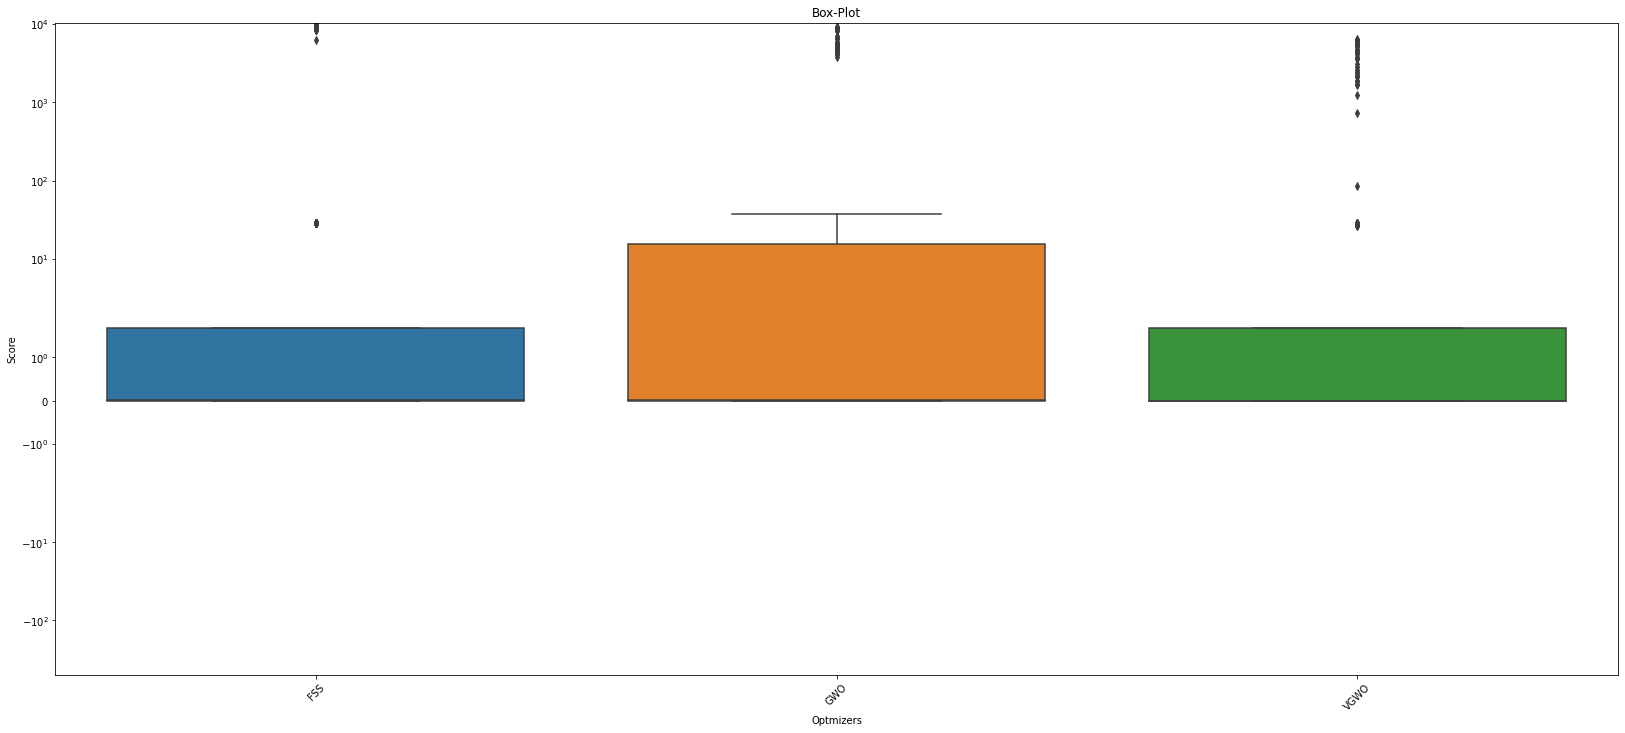

In [7]:
objective_functions = results[30]['func'].unique().tolist()
# objective_functions.remove('Levi-13')
# objective_functions.remove('Perm')
opts = results[30]['opt'].unique()
obj_show = []
for func in objective_functions:
  for o in opts[1:]:
    res = results[30][results[30]['func'] == func]
    res = res[res['opt'] == o].head(1)
    res = res.drop(['opt', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    for s in scores:
      obj_show.append({'opt': o, 'score': s})
  
res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['opt', 'score'])
# res = res[res["score"] <= 100] # remove outliers
# res = res[res["score"] >= -1000]
ax = sns.boxplot(data=res, x='opt', y='score')
ax.set_yscale('symlog')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set(xlabel= 'Optmizers', ylabel='Score', title='Box-Plot')

### Verification learning swarms in 10000 iterations

Now, for see the one execution, with 500 interation in the swarm to see the swarm evolution/learning me saved in differents files and show in graphics comparing every algoritms in the same iteration.

In [8]:
optimizers = ["PSO", "FSS", "GWO", "VGWO"]
files_100 = []
files_50 = []
files_30 = []
files_15 = []
filepath = os.path.dirname(os.path.abspath('Results'))
for opt in optimizers:
  filename = f"{filepath}/100d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_100.append(df)
  filename = f"{filepath}/50d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_50.append(df)
  filename = f"{filepath}/30d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_30.append(df)
  filename = f"{filepath}/15d/{opt}_iter.csv"
  df = pd.read_csv(filename)
  files_15.append(df)

results_15 = pd.concat(files_15)
results_15.sort_values(by=['func'], ascending=False)
results_30 = pd.concat(files_30)
results_30.sort_values(by=['func'], ascending=False)
results_50 = pd.concat(files_50)
results_50.sort_values(by=['func'], ascending=False)
results_100 = pd.concat(files_100)
results_100.sort_values(by=['func'], ascending=False)
results = {15: results_15, 30: results_30, 50: results_50, 100: results_100}
results_30.head(5)

,opt,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,PSO,Sphere,3.388904,2.139500e+02,1.611658e+02,1.611658e+02,1.611658e+02,1.320692e+02,1.320692e+02,1.320692e+02,...,1.731079e-16,1.596939e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16,1.311008e-16
1,PSO,RotatedHyperEllipsoid,9.054343,4.751300e+05,3.176430e+05,2.596008e+05,2.596008e+05,2.596008e+05,2.564614e+05,2.239103e+05,...,8.193096e-12,8.193096e-12,7.714900e-12,7.704965e-12,7.704965e-12,7.150297e-12,7.150297e-12,7.090381e-12,6.466823e-12,5.549022e-12
2,PSO,Rosenbrock,3.913796,9.749288e+05,7.360942e+05,7.099939e+05,7.099939e+05,6.346845e+05,4.619173e+05,4.619173e+05,...,4.089024e+00,4.087465e+00,4.066577e+00,4.048552e+00,4.024244e+00,4.006816e+00,4.006816e+00,3.994629e+00,3.994629e+00,3.964825e+00
3,PSO,Dixon-Price,4.545007,8.730391e+06,5.519232e+06,5.315953e+06,5.315953e+06,5.315953e+06,3.478035e+06,3.471482e+06,...,7.870387e-03,6.524244e-03,6.524244e-03,6.524244e-03,6.524244e-03,5.558138e-03,5.558138e-03,5.558138e-03,5.558138e-03,5.260805e-03
4,PSO,Quartic-Noise,3.888588,9.739375e+01,7.652279e+01,7.542459e+01,7.542459e+01,7.430618e+01,6.147767e+01,6.147767e+01,...,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00,8.060234e+00


Functions w/ 15 dim


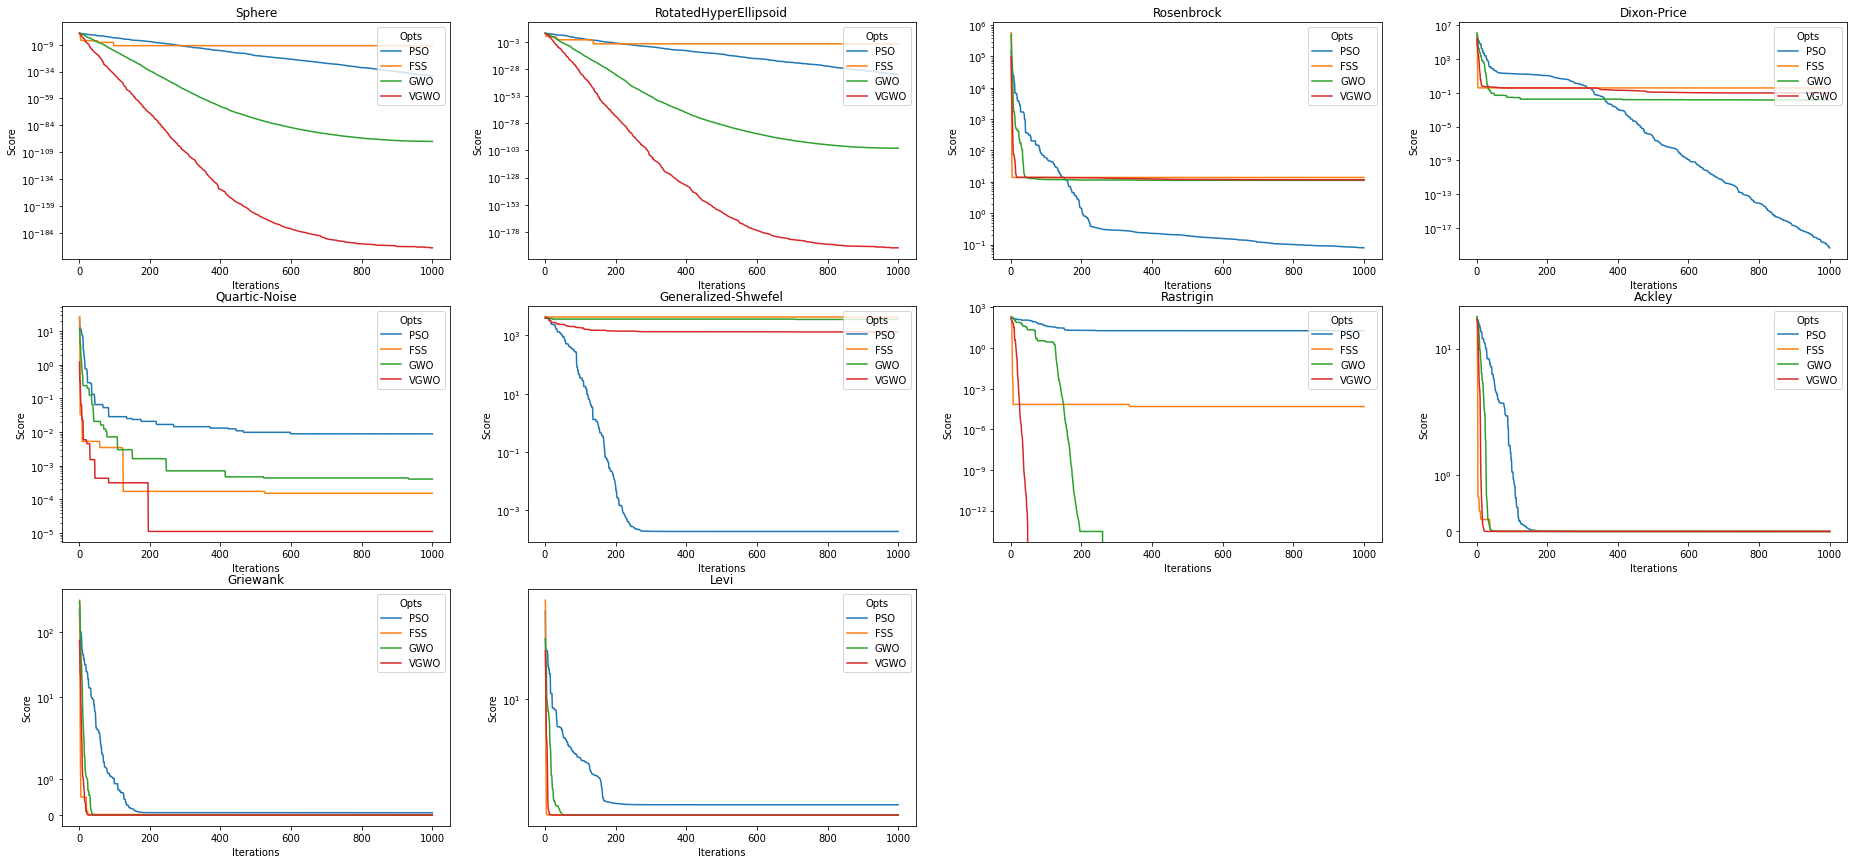

Functions w/ 30 dim


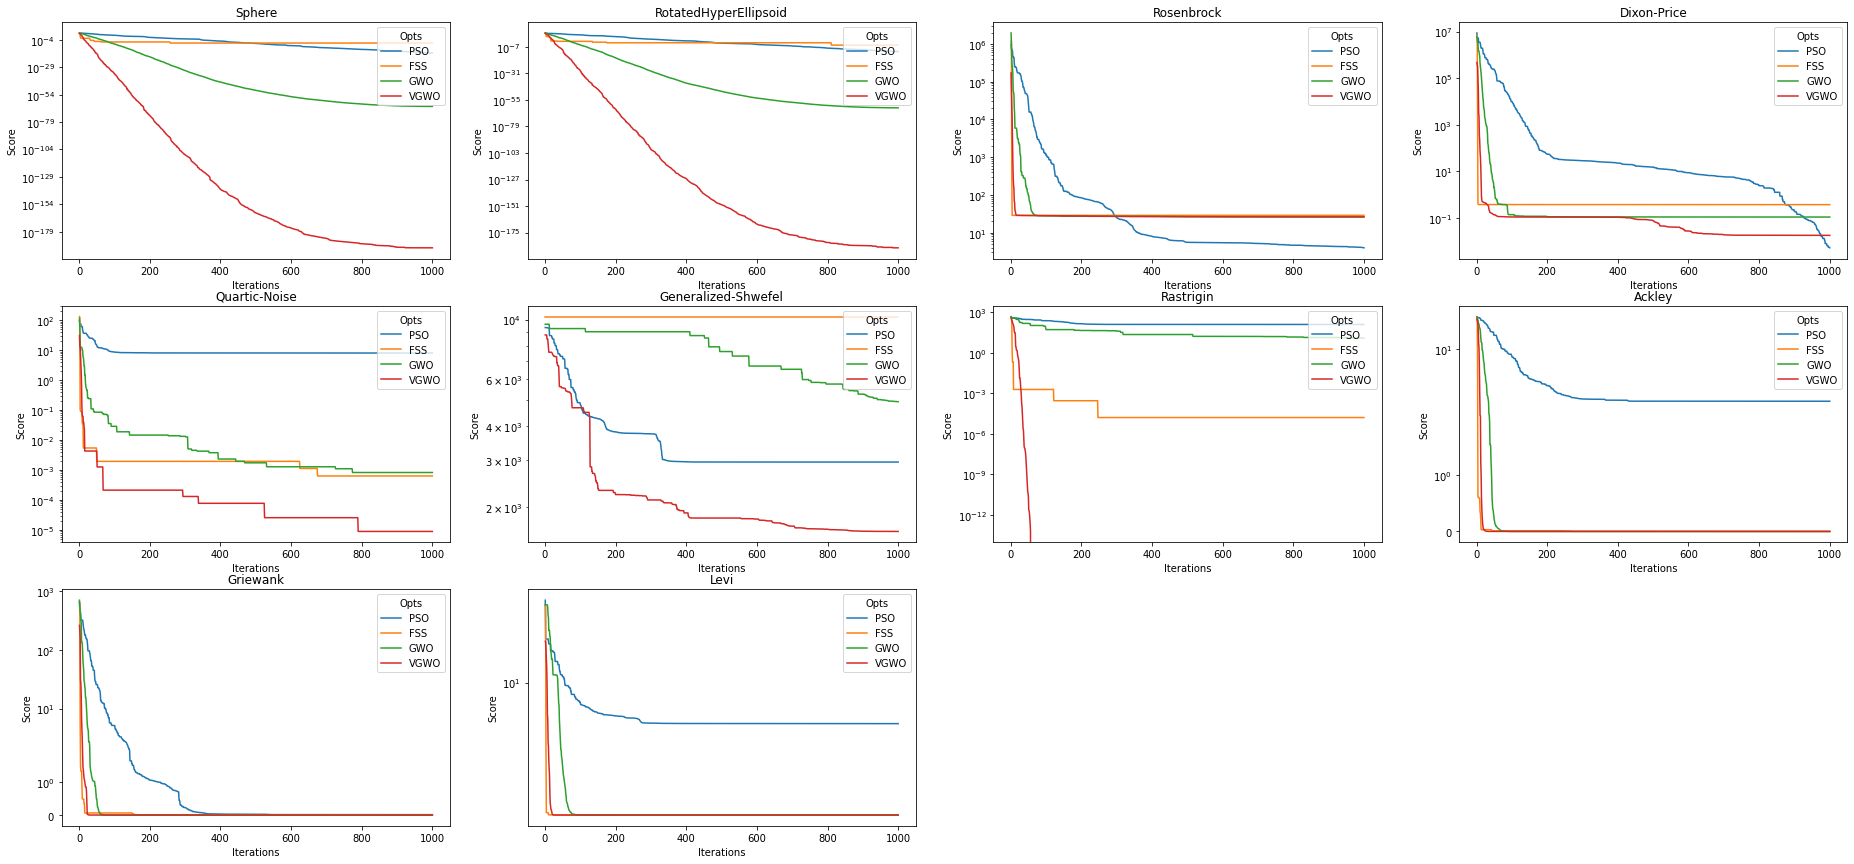

Functions w/ 50 dim


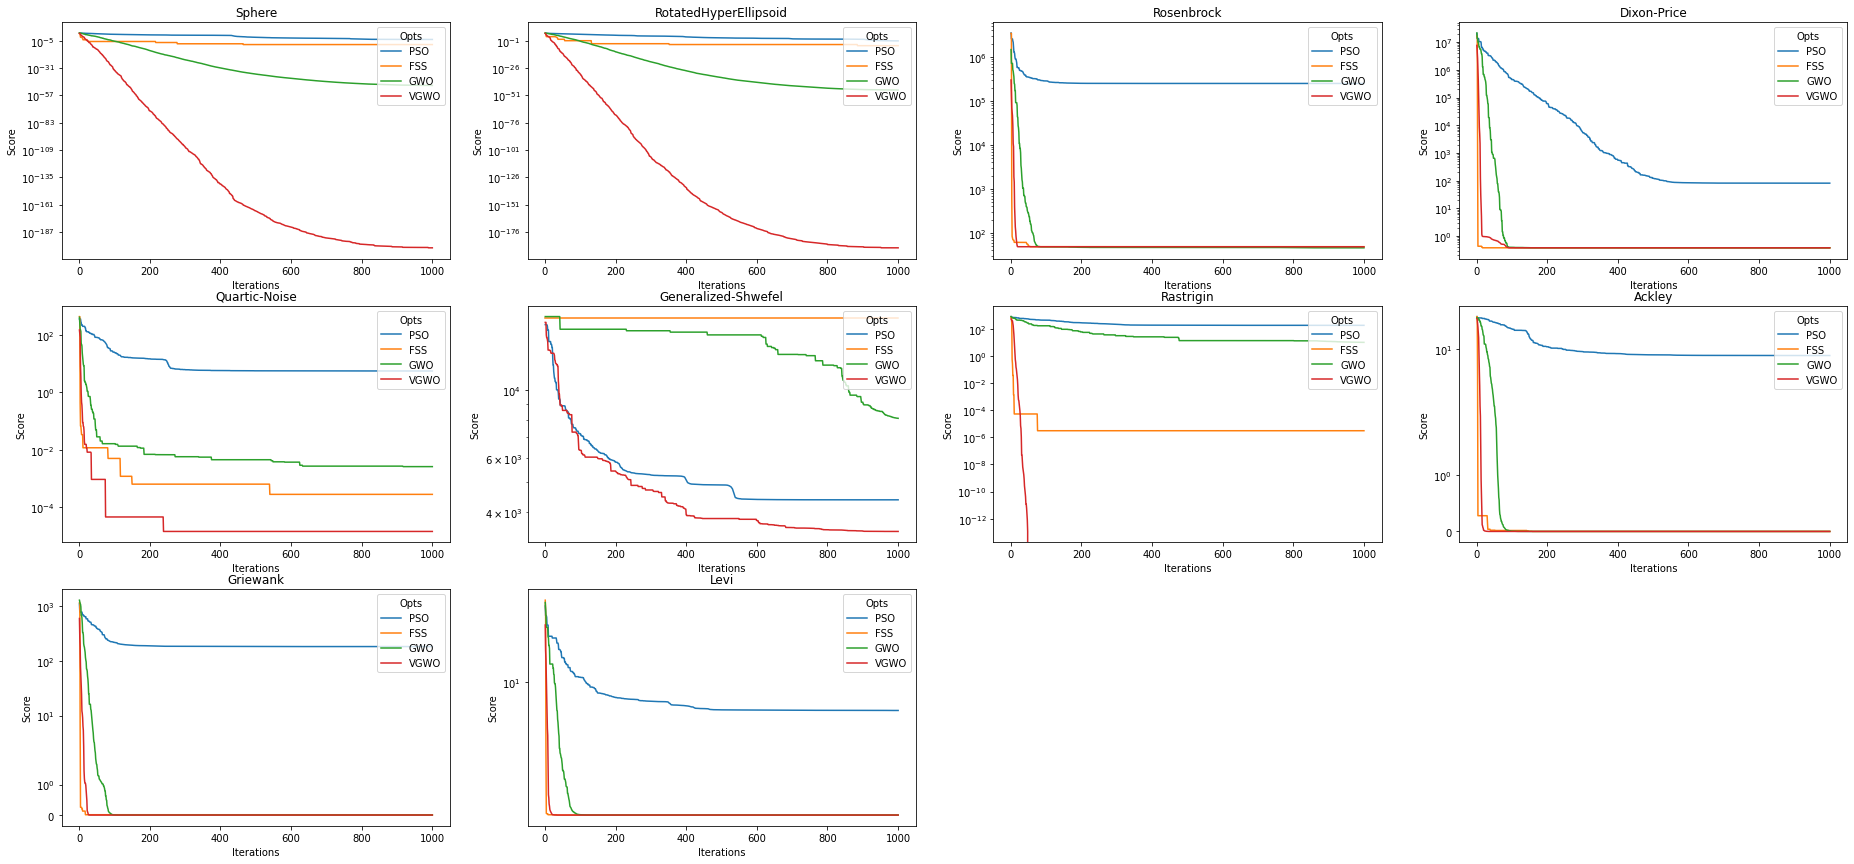

Functions w/ 100 dim


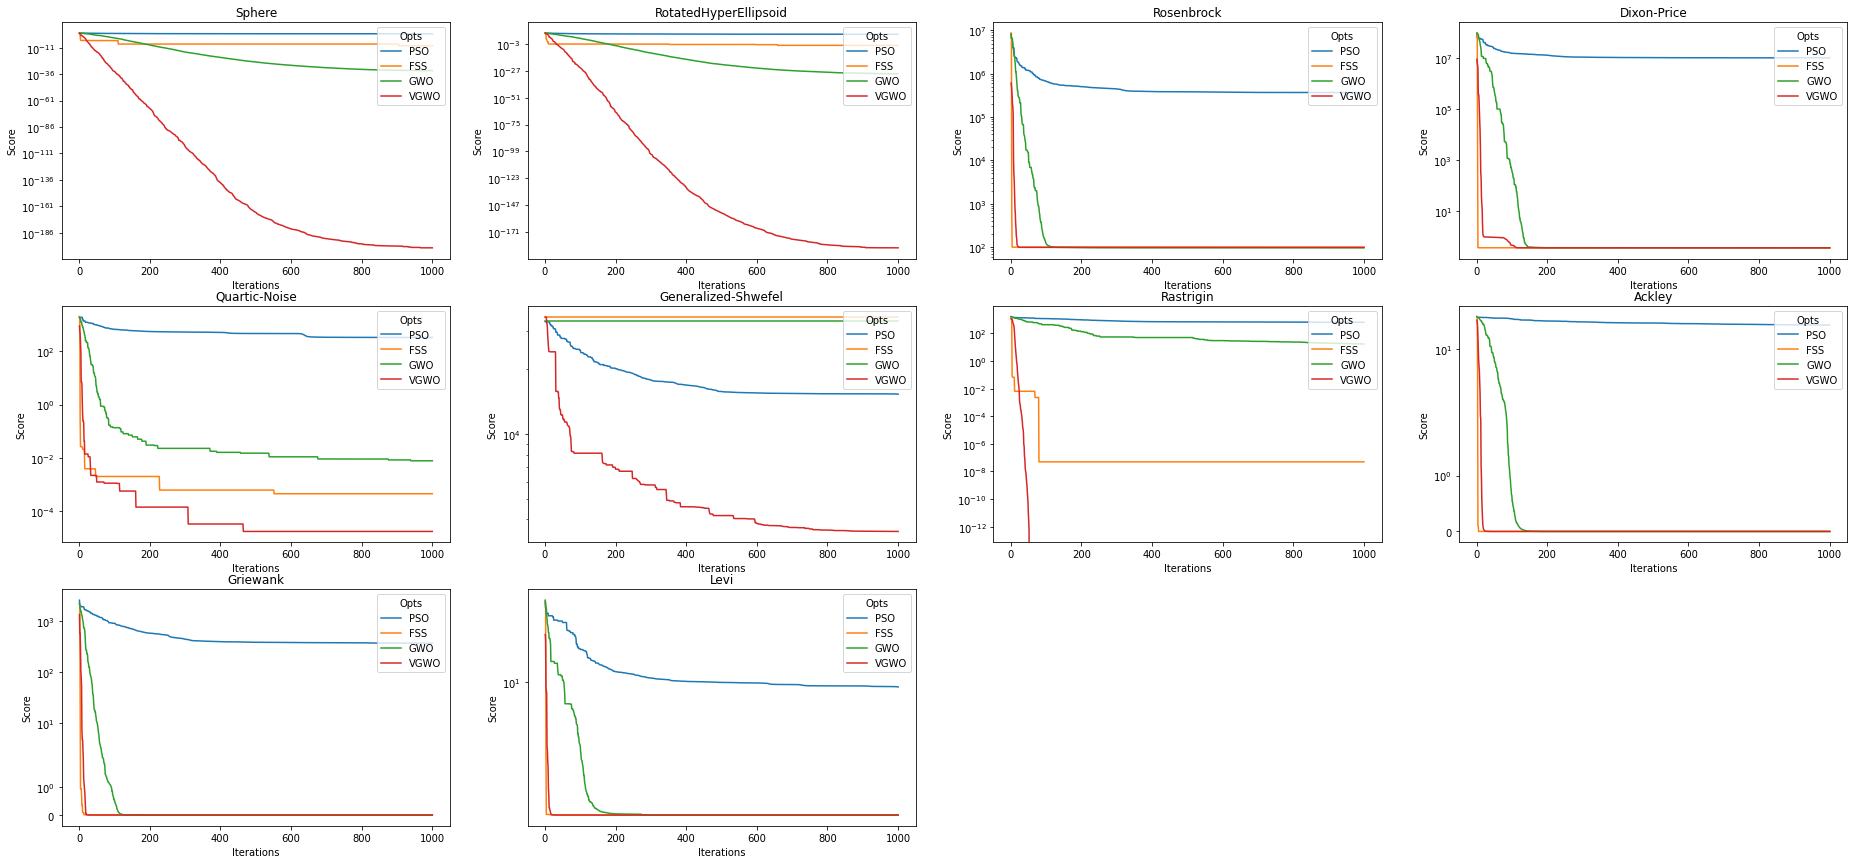

In [9]:
plt.rcParams["figure.figsize"] = (32,20)
for d in results:
  objective_functions = results[d]['func'].unique().tolist()
  # objective_functions.remove('Levi-13')
  # objective_functions.remove('Perm')
  opts = results[d]['opt'].unique()
  print(f"Functions w/ {d} dim")
  for i, func in enumerate(objective_functions):
    plt.subplot(4, 4, i+1)
    for o in opts:
      res = results[d][results[d]['func'] == func]
      res = res[res['opt'] == o].head(1)
      res = res.drop(['opt', 'func', 'exec_time'], axis=1)
      y = res.values.tolist()[0][:1000]
      min_y = np.inf
      new_y = []
      for v in y:
        if v < min_y:
          min_y = v
        new_y.append(min_y)
      y = new_y
      dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
      plt.plot(dt, label=o)
      plt.yscale('symlog' if i > 6 else 'log')
      plt.legend(loc='upper right', title="Opts")
    plt.title(func)
    plt.xlabel('Iterations')
    plt.ylabel('Score')
  plt.show()

### Verification steps volutives (15 dim)

Validate fitness curve in 300 interations

In [ ]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/{s}-vol.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run991,run992,run993,run994,run995,run996,run997,run998,run999,run1000
0,0.0001,Sphere,3.076426,44.205946,8.667306,4.134377,1.287815,1.289309,0.604422,0.373327,...,2.458285e-198,2.458101e-198,2.457864e-198,2.457778e-198,2.457631e-198,2.457542e-198,2.457458e-198,2.457400e-198,2.457378e-198,2.457368e-198
1,0.0001,RotatedHyperEllipsoid,9.420081,43395.174347,16423.302800,16171.330553,7682.407737,4082.198846,1334.736714,540.791232,...,7.347055e-198,7.346677e-198,7.345978e-198,7.345357e-198,7.345119e-198,7.344782e-198,7.344615e-198,7.344444e-198,7.344405e-198,7.344363e-198
2,0.0001,Rosenbrock,3.142190,15207.345995,15194.248438,7691.809925,7483.603069,486.024485,136.009522,25.302450,...,1.288027e+01,1.288027e+01,1.288027e+01,1.288027e+01,1.288027e+01,1.288027e+01,1.288027e+01,1.288027e+01,1.288027e+01,1.288027e+01
3,0.0001,Dixon-Price,3.545947,151988.561062,23495.158555,1715.204196,1445.624794,230.626722,203.300355,81.673070,...,1.408195e-02,1.408195e-02,1.408195e-02,1.408195e-02,1.408195e-02,1.408195e-02,1.408195e-02,1.408195e-02,1.408195e-02,1.408195e-02
4,0.0001,Quartic-Noise,3.230733,2.678333,1.257474,0.661162,0.149658,0.149658,0.094004,0.074514,...,3.528391e-03,1.011576e-02,1.011576e-02,5.122026e-02,1.791871e-03,1.791871e-03,4.678299e-03,4.678299e-03,1.886889e-02,3.558044e-02


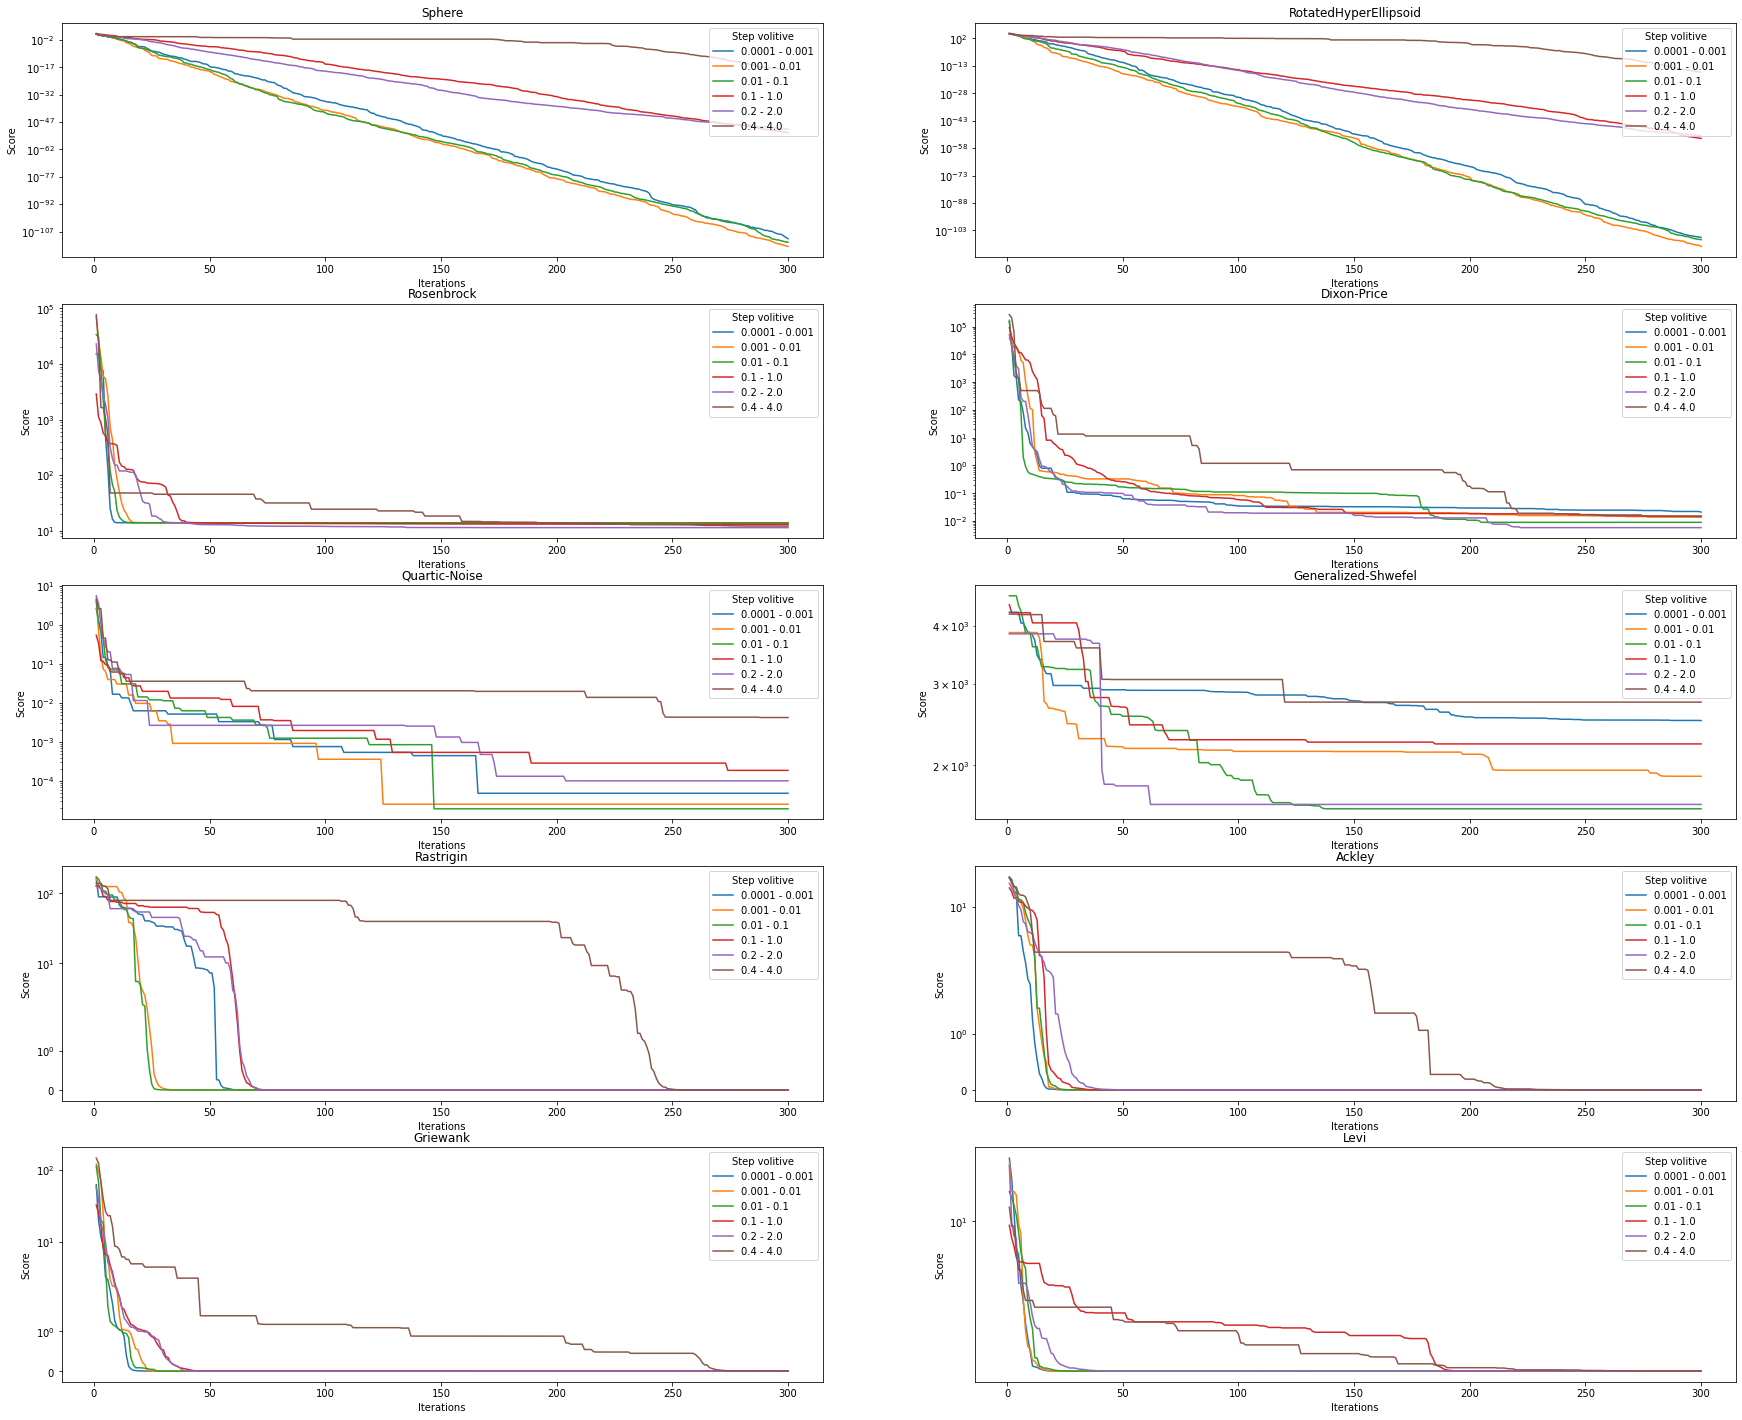

In [ ]:
plt.rcParams["figure.figsize"] = (30,25)
objective_functions = results['func'].unique().tolist()
#objective_functions.remove('Levi-13')
#objective_functions.remove('Perm')
steps = results['step_vol'].unique()
for i, func in enumerate(objective_functions):
  # if func in ['Perm', 'Levi-13']:
  #   continue
  plt.subplot(5, 2, i+1)
  for s in steps:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == s].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    y = res.values.tolist()[0][:300]
    min_y = np.inf
    new_y = []
    for v in y:
      if v < min_y:
        min_y = v
      new_y.append(min_y)
    y = new_y
    dt = pd.DataFrame(data=y, index=range(1, len(y)+1), columns=['score'])
    plt.plot(dt, label=f"{s} - {s*10}")
    plt.legend(loc='upper right', title='Step volitive')
    plt.yscale('symlog' if i > 5 else 'log')
  plt.title(func)
  plt.xlabel('Iterations')
  plt.ylabel('Score')
  # plt.text(0, 0, string.ascii_uppercase[i], size=20, weight='bold')
plt.show()

Validation fitness variance in 30 executions

In [ ]:
steps = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.4]
files = []
filepath = os.path.dirname(os.path.abspath('Results'))
for s in steps:
  filename = f"{filepath}/VGWO-vol/VGWO_exec_{s}.csv"
  df = pd.read_csv(filename)
  files.append(df)

results = pd.concat(files)
results.sort_values(by=['func'], ascending=False)
results.head(5)

,step_vol,func,exec_time,run1,run2,run3,run4,run5,run6,run7,...,run21,run22,run23,run24,run25,run26,run27,run28,run29,run30
0,0.0001,Sphere,90.751798,9.560121e-210,1.758149e-193,7.179759e-193,3.569898e-200,1.748827e-198,3.210322e-201,1.441519e-201,...,4.221572e-199,4.822890e-210,1.956090e-204,1.745888e-198,9.596450e-206,4.707352e-208,7.458491e-207,8.868451e-212,1.970308e-201,1.340252e-203
1,0.0001,RotatedHyperEllipsoid,272.655077,5.087376e-189,3.532976e-200,9.269816e-199,1.469892e-197,1.248367e-193,8.740707e-196,3.229175e-197,...,2.382516e-202,1.117282e-191,1.086422e-194,1.348125e-206,1.403799e-199,3.380141e-212,4.543581e-199,2.204039e-204,6.980485e-191,3.137985e-202
2,0.0001,Rosenbrock,93.422985,1.386435e+01,1.355369e+01,1.250643e+01,1.219739e+01,1.323985e+01,1.295082e+01,1.379944e+01,...,1.228768e+01,1.209309e+01,1.278135e+01,1.387606e+01,1.349612e+01,1.384402e+01,1.275406e+01,1.350474e+01,1.345630e+01,1.318013e+01
3,0.0001,Dixon-Price,106.603364,1.459479e-01,4.676910e-02,1.945903e-02,1.617236e-02,1.073185e-01,1.005240e-01,2.774617e-02,...,3.742898e-01,1.064148e-01,1.031773e-01,1.099798e-01,1.098657e-01,2.892704e-02,1.108455e-01,1.098561e-01,1.361728e-02,3.750083e-01
4,0.0001,Quartic-Noise,97.494265,1.567438e-05,4.200906e-06,5.121672e-05,2.543937e-06,2.888913e-07,2.967664e-05,4.703382e-06,...,7.202394e-05,6.748082e-06,6.732315e-06,1.940409e-05,4.036868e-06,1.518094e-05,1.891862e-05,1.868757e-05,2.139328e-05,1.539145e-05


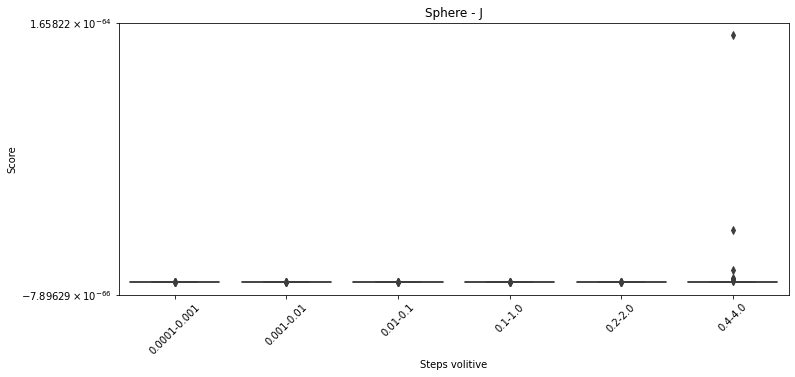

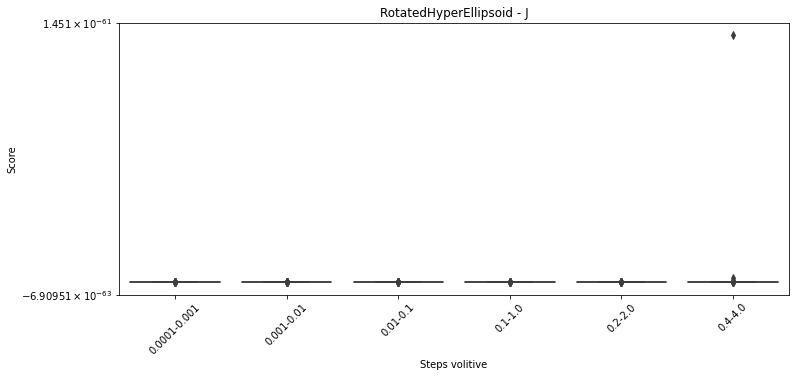

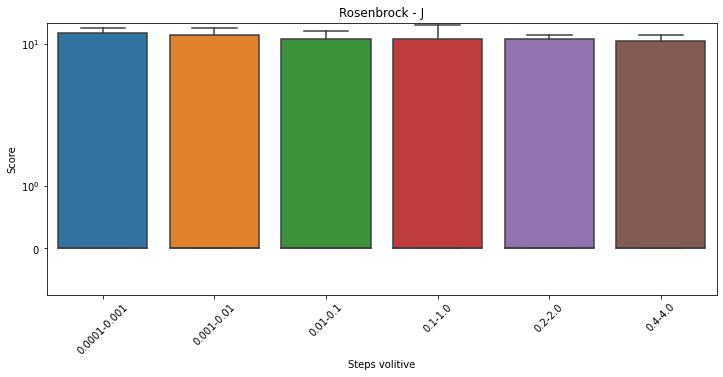

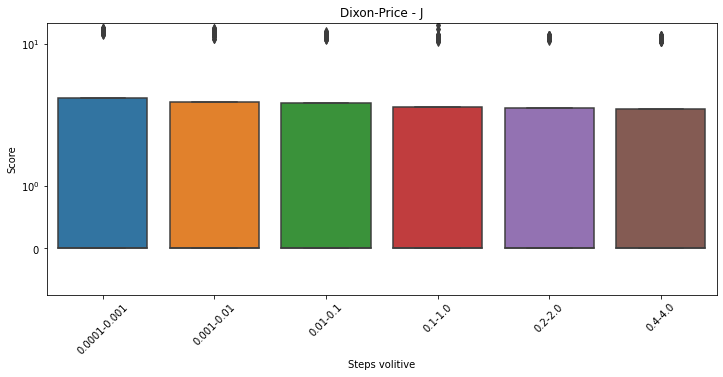

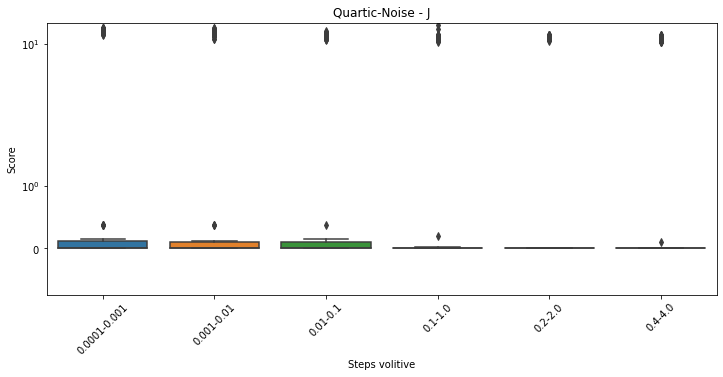

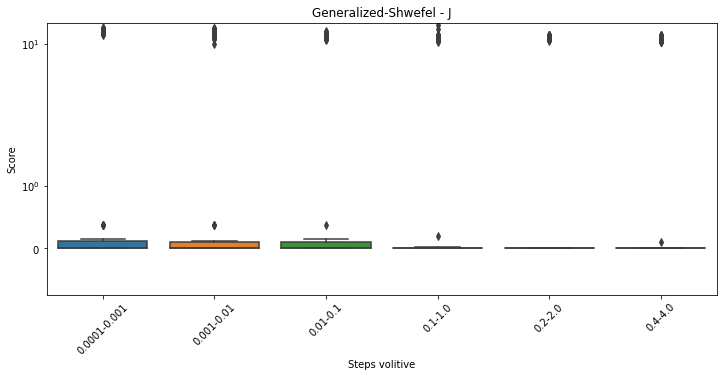

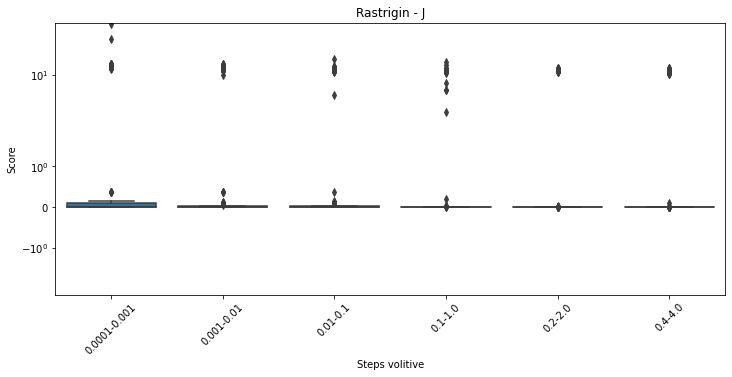

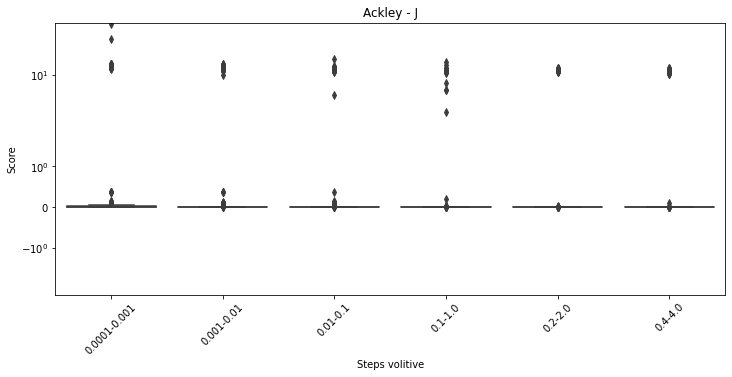

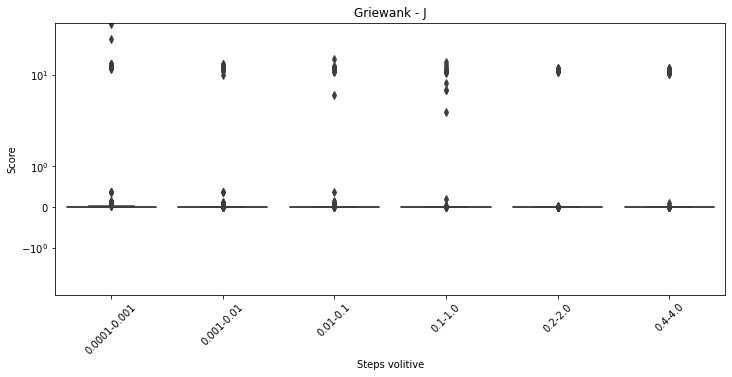

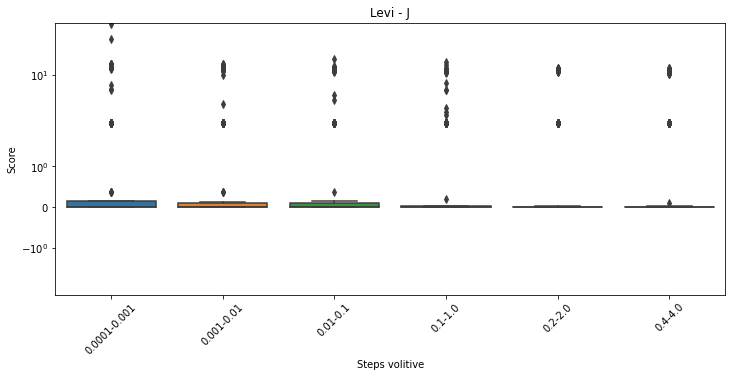

In [ ]:
plt.rcParams["figure.figsize"] = (12,5)
tb_dt = {}
objective_functions = results['func'].unique().tolist()
# objective_functions.remove('Levi-13')
# objective_functions.remove('Perm')
steps_vol = results['step_vol'].unique()
obj_show = []
for func in objective_functions:
  tb_dt[func] = {}
  for v in steps_vol:
    res = results[results['func'] == func]
    res = res[res['step_vol'] == v].head(1)
    res = res.drop(['step_vol', 'func', 'exec_time'], axis=1)
    scores = res.values.tolist()[0]
    tb_dt[func][v] = scores
    for s in scores:
      obj_show.append({'step': f"{v}-{v*10}", 'score': s})
  
  res = pd.DataFrame(data=obj_show, index=range(len(obj_show)), columns=['step', 'score'])
  res = res[res["score"] <= 60] # remove outliers
  # res = res[res["score"] >= -1000]
  ax = sns.boxplot(data=res, x='step', y='score')
  ax.set_yscale('symlog')
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set(xlabel='Steps volitive', ylabel='Score', title=f"{func} - {string.ascii_uppercase[i]}")
  plt.show()

In [ ]:
dt_func = []
for func in tb_dt:
  print(f"{func}")
  for v in tb_dt[func]:
    vols = list(tb_dt[func].keys())
    size_tb = len(tb_dt[func][v])
    lines = [[tb_dt[func][vol][i] for vol in vols] for i in range(size_tb)]
    dt = pd.DataFrame(data=lines, index=range(1, len(tb_dt[func][v])+1), columns=vols)
    dt_func.append(dt)

  # print(dt.describe())
  # print()
  display(dt.describe().loc[:].style.highlight_min(axis=1, props='color:white; font-weight:bold; background-color:green;'))

Sphere


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


RotatedHyperEllipsoid


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Rosenbrock


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,13.101937,12.439960,11.782322,11.628136,11.505391,11.169121
std,0.594024,0.679187,0.552664,0.838849,0.434543,0.531945
min,12.093090,11.143305,10.956323,10.482047,10.753702,10.355789
25%,12.548599,12.059770,11.230189,11.185372,11.182876,10.732255
50%,13.209989,12.182706,11.853155,11.427559,11.268028,11.155759
75%,13.589878,12.874189,12.129286,12.018451,11.906550,11.460044
max,13.876057,13.868259,13.013311,14.724228,12.159879,12.147291


Dixon-Price


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.119336,0.077575,0.058148,0.011854,0.005517,0.008826
std,0.124156,0.111128,0.079386,0.034630,0.006096,0.019794
min,0.002052,0.000420,0.000785,0.000849,0.000184,0.000731
25%,0.024896,0.004781,0.002339,0.001513,0.001000,0.001225
50%,0.104796,0.015740,0.014151,0.002449,0.001367,0.001499
75%,0.116656,0.109967,0.109869,0.012418,0.013626,0.011842
max,0.375008,0.375000,0.375000,0.192899,0.014333,0.109859


Quartic-Noise


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000017,0.000022,0.000020,0.000017,0.000023,0.000034
std,0.000018,0.000018,0.000017,0.000013,0.000023,0.000046
min,0.000000,0.000002,0.000000,0.000000,0.000001,0.000002
25%,0.000005,0.000007,0.000008,0.000007,0.000004,0.000006
50%,0.000013,0.000018,0.000017,0.000014,0.000012,0.000015
75%,0.000019,0.000030,0.000026,0.000024,0.000041,0.000040
max,0.000072,0.000070,0.000068,0.000049,0.000068,0.000182


Generalized-Shwefel


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2133.792042,1621.835860,1682.936972,3184.942637,2696.381830,1552.422892
std,584.928154,717.452104,814.954694,482.928078,577.623078,581.399117
min,926.038917,9.997424,224.038936,1612.564902,665.473173,411.402555
25%,1766.616335,1196.899730,1182.643462,2949.049682,2404.551977,1131.027093
50%,2045.238933,1740.219545,1718.067622,3224.342636,2847.170408,1640.692806
75%,2659.567722,2156.945306,2272.499361,3496.236907,3018.637509,1941.590488
max,3227.131471,2925.931430,3430.063568,3998.764223,3574.485855,2799.145974


Rastrigin


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.637534,0.000000,0.724628,0.767291,0.000000,0.000000
std,10.320099,0.000000,3.134926,2.083891,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,48.697119,0.000000,16.546964,7.728521,0.000000,0.000000


Ackley


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
std,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Griewank


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,0.001088,0.000000,0.001859,0.000970,0.001080,0.001633
std,0.005961,0.000000,0.006159,0.003786,0.004399,0.004949
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.032649,0.000000,0.029101,0.017749,0.022164,0.023826


Levi


,0.0001,0.001,0.01,0.1,0.2,0.4
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,2.601989,2.221939,2.239179,2.229549,2.160439,2.160474
std,1.357765,0.340102,0.434533,0.264289,0.003256,0.003448
min,2.159845,2.159845,2.159845,2.159845,2.159845,2.159845
25%,2.159845,2.159845,2.159845,2.159845,2.159845,2.159845
50%,2.159845,2.159845,2.159845,2.159845,2.159845,2.159845
75%,2.159845,2.159845,2.159845,2.159845,2.159845,2.159845
max,7.253676,4.022662,4.539879,3.467512,2.177677,2.178729
